<a href="https://colab.research.google.com/github/claudio-bon/fact-checking-fever/blob/main/fact_checking_fever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

**Due to**: TBD

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Fact checking, Neural Languange Inference (**NLI**)

# Intro

This assignment is centred on a particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given statement (fact) conveys a trustworthy information or not. 

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

In particular, we will see:

*   Dataset preparation (analysis and pre-processing)
*   Problem formulation: multi-input binary classification
*   Defining an evaluation method
*   Simple sentence embedding
*   Neural building blocks
*   Neural architecture extension

# The FEVER dataset

First of all, we need to choose a dataset. In this assignment we will rely on the [FEVER dataset](https://fever.ai).

The dataset is about facts taken from Wikipedia documents that have to be verified. In particular, facts could face manual modifications in order to define fake information or to give different formulations of the same concept.

The dataset consists of 185,445 claims manually verified against the introductory sections of Wikipedia pages and classified as ```Supported```, ```Refuted``` or ```NotEnoughInfo```. For the first two classes, systems and annotators need to also return the combination of sentences forming the necessary evidence supporting or refuting the claim.

## Dataset structure

Relevant data is divided into two file types. Information concerning the fact to verify, its verdict and associated supporting/opposing statements are stored in **.jsonl** format. In particular, each JSON element is a python dictionary with the following relevant fields:

*    **ID**: ID associated to the fact to verify.

*    **Verifiable**: whether the fact has been verified or not: ```VERIFIABLE``` or ```NOT VERIFIABLE```.
    
*    **Label**: the final verdict on the fact to verify: ```SUPPORTS```, ```REFUTES``` or ```NOT ENOUGH INFO```.
    
*    **Claim**: the fact to verify.
    
*    **Evidence**: a nested list of document IDs along with the sentence ID that is associated to the fact to verify. In particular, each list element is a tuple of four elements: the first two are internal annotator IDs that can be safely ignored; the third term is the document ID (called URL) and the last one is the sentence number (ID) in the pointed document to consider.

**Some Examples**

---

**Verifiable**

{"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}

---

**Not Verifiable**

{"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}

---

## Some simplifications and pre-processing

We are only interested in verifiable facts. Thus, we can filter out all non-verifiable claims.

Additionally, the current dataset format does not contain all necessary information for our classification purposes. In particular, we need to download Wikipedia documents and replace reported evidence IDs with the corresponding text.

Don't worry about that! We are providing you the already pre-processed dataset so that you can concentrate on the classification pipeline (pre-processing, model definition, evaluation and training).

You can download the zip file containing all set splits (train, validation and test) of the FEVER dataset by clicking on this [link](https://drive.google.com/file/d/1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1/view?usp=sharing). Alternatively, run the below code cell to automatically download it on this notebook.

**Note**: each dataset split is in .csv format. Feel free to inspect the whole dataset!

# Classification dataset

At this point, you should have a reay-to-go dataset! Note that the dataset format changed as well! In particular, we split the evidence set associated to each claim, in order to build (claim, evidence) pairs. The classification label is propagated as well.

We'll motivate this decision in the next section!

Just for clarity, here's an example of the pre-processed dataset:

---

**Claim**: "Wentworth Miller is yet to make his screenwriting debut."

**Evidence**: "2	He made his screenwriting debut with the 2013 thriller film Stoker .	Stoker	Stoker (film)"

**Label**: Refutes

---

**Note**: The dataset requires some text cleaning as you may notice!


# Problem formulation

As mentioned at the beginning of the assignment, we are going to formulate the fact checking problem as a binary classification task.

In particular, each dataset sample is comprised of:

*     A claim to verify
*     A set of semantically related statements (evidence set)
*     Fact checking label: either evidences support or refute the claim.

Handling the evidence set from the point of view of neural models may imply some additional complexity: if the evidence set is comprised of several sentences we might incur in memory problems.

To this end, we further simplify the problem by building (claim, evidence) pairs. The fact checking label is propagated as well.

Example:

     Claim: c1 
     Evidence set: [e1, e2, e3]
     Label: S (support)

--->

    (c1, e1, S),
    (c1, e2, S),
    (c1, e3, S)

## Schema

The overall binary classification problem is summed up by the following (simplified) schema

![](https://drive.google.com/uc?export=view&id=1Wm_YBnFwgJtxcWEBpPbTBEVkpKaL08Jp)

Don't worry too much about the **Encoding** block for now. We'll give you some simple guidelines about its definition. For the moment, stick to the binary classification task definition where, in this case, we have 2 inputs: the claim to verify and one of its associated evidences.

# Architecture Guidelines

There are many neural architectures that follow the above schema. To avoid phenomena like the writer's block, in this section we are going to give you some implementation guidelines.

In particular, we would like you to test some implementations so that you explore basic approaches (neural baselines) and use them as building blocks for possible extensions.

## Handling multiple inputs

The first thing to notice is that we are in a multi-input scenario. In particular, each sample is comprised of a fact and its associated evidence statement.

Each of these input is encoded as a sequence of tokens. In particular, we will have the following input matrices:

*    Claim: [batch_size, max_tokens]
*    Evidence: [batch_size, max_tokens]

Moreover, after the embedding layer, we'll have:

*    Claim: [batch_size, max_tokens, embedding_dim]
*    Evidence: [batch_size, max_tokens, embedding_dim]

But, we would like to have a 2D input to our classifier, since we have to give an answer at pair level. Therefore, for each sample, we would expect the following input shape to our classification block:

*   Classification input shape: [batch_size, dim]

**How to do that?**

We inherently need to reduce the token sequence to a single representation. This operation is formally known as **sentence embedding**. Indeed, we are trying to compress the information of a whole sequence into a single embedding vector.

Here are some simple solutions that we ask you to try out:

*   Encode token sequences via a RNN and take the last state as the sentence embedding.

*   Encode token sequences via a RNN and average all the output states.

*   Encode token sequences via a simple MLP layer. In particular, if your input is a [batch_size, max_tokens, embedding_dim] tensor, the matrix multiplication works on the **max_tokens** dimension, resulting in a [batch_size, embedding_dim] 2D matrix.

*   Compute the sentence embedding as the mean of its token embeddings (**bag of vectors**).

## Merging multi-inputs

At this point, we have to think about **how** we should merge evidence and claim sentence embeddings.

For simplicity, we stick to simple merging strategies:

*     **Concatenation**: define the classification input as the concatenation of evidence and claim sentence embeddings

*     **Sum**: define the classification input as the sum of evidence and claim sentence embeddings

*     **Mean**: define the classification input as the mean of evidence and claim sentence embeddings

For clarity, if we the sentence embedding of a single input has shape [batch_size, embedding_dim], then the classification input has shape:

*     **Concatenation**: [batch_size, 2 * embedding_dim]

*     **Sum**: [batch_size, embedding_dim]

*     **Mean**: [batch_size, embedding_dim]

# A simple extension

Lastly, we ask you to modify previously defined neural architectures by adding an additional feature to the classification input.

We would like to see if some similarity information between the claim to verify and one of its associated evidence might be useful to the classification.

Compute the cosine similarity metric between the two sentence embeddings and concatenate the result to the classification input.

For clarity, since the cosine similarity of two vectors outputs a scalar value, the classification input shape is modified as follows:

*     **Concatenation**: [batch_size, 2 * embedding_dim + 1]

*     **Sum**: [batch_size, embedding_dim + 1]

*     **Mean**: [batch_size, embedding_dim + 1]



# Performance evaluation

Due to our simplifications, obtained results are not directly compatible with a traditional fact checking method that considers the evidence set as a whole.

Thus, we need to consider two types of evaluations.

**Multi-input classification evaluation**

This type of evaluation is the easiest and concerns computing evaluation metrics, such as accuracy, f1-score, recall and precision, of our pre-processed dataset.

In other words, we assess the performance of chosen classifiers.

**Claim verification evaluation**

However, if we want to give an answer concerning the claim itself, we need to consider the whole evidence set. 

Intuitively, for a given claim, we consider all its corresponding (claim, evidence) pairs and their corresponding classification outputs. 

At this point, all we need to do is to compute the final predicted claim label via majority voting.

Example:

    Claim: c1
    Evidence set: e1, e2, e3
    True label: S

    Pair outputs:
    (c1, e1) -> S (supports)
    (c1, e2) -> S (supports)
    (c1, e3) -> R (refutes)

    Majority voting:
    S -> 2 votes
    R -> 1 vote

    Final label:
    c1 -> S

Lastly, we have to compute classification metrics just like before.

# Tips and Extras

## Extensions are welcome!

Is this task too easy for you? Are you curious to try out things you have seen during lectures (e.g. attention)? Feel free to try everything you want!

Don't forget to try neural baselines first!

## Comments and documentation

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

## Organization

We suggest you to divide your work into sections. This allows you to build clean and modular code, as well as easy to read and to debug.

A possible schema:

*   Dataset pre-processing
*   Dataset conversion
*   Model definition
*   Training
*   Evaluation
*   Comments/Summary

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

Don't forget that your feedback is very important! Your suggestions help us improving course material.

# FAQ

---

**Q: Can I do something text pre-processing?**

**A:** You have to! If you check text data, the majority of sentences need some cleaning.

---

**Q: I'm struggling with the implementation. Can you help me?**

**A:** Yes sure! Write us an email about your issue. If you are looking for a particular type of operation, you can easily check the documentation of the deep learning framework you are using (google is your friend).

---

**Q: Can I try other encoding strategies or neural architectures?**

**A:** Absolutely! Remember to try out recommended neural baselines first and only then proceed with your extensions.

---

# Initial Imports

In [ ]:
# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# system packages
import os
import shutil
import sys
import time
import random
import gc

# data and numerical management packages
import pandas as pd
import numpy as np
import torch
import math

# data for preprocessing
import re
from functools import reduce
! pip install joblib
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud, ImageColorGenerator
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer 
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
import json
! pip install pytorch-nlp
from torchnlp.word_to_vector import FastText  # doctest: +SKIP

# plotting-displaying packages
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt

# debugging packages (progress bars)
from tqdm.notebook import tqdm



random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True


if torch.cuda.is_available():
    print('Used device: GPU')
    device = torch.device("cuda")
else:
    print('Used device: CPU')
    device = torch.device("cpu")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
     |████████████████████████████████| 92kB 7.8MB/s 
Used device: GPU


# Data Loading

### Dataset Downloading

In [ ]:
import os
import requests
import zipfile

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


### DataFrame Creation

# Dataset Preprocessing

In [ ]:
def create_df(dataset_name):
    dataframe_rows = []
    file_path = os.path.join(os.getcwd(), "dataset", dataset_name)
    try:
        if os.path.isfile(file_path):
            # open the file
            with open(file_path, mode='r', encoding='utf-8') as text_file:
                lines = text_file.readlines()   
                # Starting from the 2nd line to exclude
                for line in tqdm(lines[1: len(lines)]): 
                  # Excluding empty lines
                  if len(line.strip()) > 0:
                    line = re.sub('"', '', line)
                    # Replacing the possible starts of the evidence with an special identifier
                    if re.findall('[?],[0-9]+', line):
                      line = re.sub('[?],[0-9]+', '_SEVID_', line,1)
                    if not re.findall('_SEVID_', line) and re.findall('[.],[0-9]+', line):
                      line = re.sub('[.],[0-9]+', '_SEVID_', line,1)
                    if not re.findall('_SEVID_', line) and re.findall(',[0-9]+', line):
                      line = re.sub(',[0-9]+', '_SEVID_', line,1)
                    id =  line.split(",")[0]
                    #claim = line.split(",")[1].split('_SEVID_')[0]
                    #if (len(re.findall('_SEVID_', line))) > 1:
                    claim = line.split('_SEVID_')[0].split(",",maxsplit=1)[-1]
                    evidence = line.split('_SEVID_')[-1]
                    # Most of evidences have repeated information after the last point
                    repeated_info = evidence.split(".")[-1]
                    if evidence != repeated_info: evidence = evidence.replace(repeated_info, "") 
                    id_claim = line.split(",")[-2] 
                    label = line.split(",")[-1].split("\n")[0]
                    evidence = evidence.replace(label, "") 
                    evidence = evidence.replace(id_claim, "") 
                    # create single dataframe row
                    dataframe_row = {
                        "id": id,
                        "claim": claim,
                        "evidence": evidence,
                        "id_claim": id_claim,
                        "label": label
                    }
                    dataframe_rows.append(dataframe_row)

    except Exception as e:
        print('Failed to process %s. Reason: %s' % (file_path, e))
        sys.exit(0)

    folder = os.path.join(os.getcwd(), "dataset", "Dataframes", dataset_name)
    if not os.path.exists(folder):
        os.makedirs(folder)

    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["id",
            "claim",
            "evidence",
            "id_claim",
            "label"]]
    dataframe_path = os.path.join(folder, dataset_name + ".pkl")
    df.to_pickle(dataframe_path)
    return df

# Creating dataframes
print("Creating dataframe...")
df_train = create_df('train_pairs.csv')
df_val = create_df('val_pairs.csv')
df_test = create_df('test_pairs.csv')
# small datasets for faster applications
df_train_10perc = df_train[0: round(0.10* len(df_train))]
df_val_10perc = df_val[0: round(0.10* len(df_val))]
df_test_10perc = df_test[0: round(0.10* len(df_test))]
print("Dataframe completed!")

# Saving the evidence and claim corpus before any modification with preprocessing
corpus_evidence_bfp = df_train['evidence'].str.lower().str.split()
corpus_claim_bfp = df_train['claim'].str.lower().str.split()

Creating dataframe...



Dataframe completed!


In [ ]:
'''
Checking the correctness of the data
Some claim and evidences in the train were noisy, very hard to detect in the process of df creation
For that reason, we found the samples with problems and according to the number resulting
we decide to delete or apply more preprocessing techniques only to those.

Note: As we found only 33 samples in the train df with problems, we decided to delete them
Test and validation were checked only for  purpose of information
'''

train_Iderror = []
val_Iderror = []
test_Iderror = []

for id, data in df_train.iterrows():
  if len(data['evidence']) <= 1 or re.findall('_SEVID_', data['evidence']) \
      or len(data['claim']) <= 1 or re.findall('_SEVID_', data['claim']) \
      or len(data['id']) == 0 or re.findall('_SEVID_', data['id']) \
      or len(data['id_claim']) == 0 or re.findall('_SEVID_', data['id_claim']) \
      or len(data['label']) == 0 or re.findall('_SEVID_', data['label']):
    train_Iderror.append(id) 

for id, data in df_val.iterrows():
  if len(data['evidence']) <= 1 or re.findall('_SEVID_', data['evidence']) \
      or len(data['claim']) <= 1 or re.findall('_SEVID_', data['claim']) \
      or len(data['id']) == 0 or re.findall('_SEVID_', data['id']) \
      or len(data['id_claim']) == 0 or re.findall('_SEVID_', data['id_claim']) \
      or len(data['label']) == 0 or re.findall('_SEVID_', data['label']):
    val_Iderror.append(id) 

for id, data in df_test.iterrows():
  if len(data['evidence']) <= 1 or re.findall('_SEVID_', data['evidence']) \
      or len(data['claim']) <= 1 or re.findall('_SEVID_', data['claim']) \
      or len(data['id']) == 0 or re.findall('_SEVID_', data['id']) \
      or len(data['id_claim']) == 0 or re.findall('_SEVID_', data['id_claim']) \
      or len(data['label']) == 0 or re.findall('_SEVID_', data['label']):
    test_Iderror.append(id) 

print("Were found {} errors in the data train".format(len(train_Iderror))) 
print("Were found {} errors in the data val".format(len(val_Iderror))) 
print("Were found {} errors in the data test".format(len(test_Iderror))) 

# list of indexes without errors
l_idx = [i for i in df_train.index if int(i) not in train_Iderror ]

# Creating a view without the samples with error
df_train = df_train.loc[l_idx]
# Re indexing the dataframe
df_train = df_train.reset_index(drop=True)
#df_train = df_train.drop(train_Iderror)

print("{} rows were dropped out from the train df".format(len(train_Iderror)))
# Saving the evidence and claim corpus before any modification with preprocessing
corpus_evidence_bfp = df_train['evidence'].str.lower().str.split()
corpus_claim_bfp = df_train['claim'].str.lower().str.split()

Were found 33 errors in the data train
Were found 0 errors in the data val
Were found 0 errors in the data test
33 rows were dropped out from the train df


### Definition of the pipeline

In [ ]:
# Settings for the preprocessing
# Some functions were inspired on [1]

SPLIT = re.compile(r'\w+')
DATA_BW_PARENTHESES = re.compile('\[.*?\]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z +]')
CONVERT_PARENTHESES = [
                (re.compile(r"-LRB-"), "("),
                (re.compile(r"-RRB-"), ")"),
                (re.compile(r"-LSB-"), "["),
                (re.compile(r"-RSB-"), "]"),
                (re.compile(r"-LCB-"), "{"),
                (re.compile(r"-RCB-"), "}"),
            ]
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def download_file(data_path, filename, url):
    '''
    Function to download a file and save it in memory
    '''
    data_path_file = os.path.join(data_path, filename)
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    if not os.path.exists(data_path_file):
        print("Downloading data ...")
        with requests.Session() as current_session:
            response = current_session.get(url, stream=True)
        save_response_content(response, data_path_file)
        print("Download completed!")

# Downloading the file of enlish contractions useful for normalizing the data
url_contractions = 'https://gist.githubusercontent.com/Sirsirious/c70400176a4532899a483e06d72cf99e/raw/e46fa7620c4f378f5bf39608b45cddad7ff447a4/english_contractions.json'
download_file('resources', 'english_contractions.json', url_contractions)


#######################################################################################
#                       Some functions for preprocessing
#######################################################################################

def lower(text):
    """
    Transforms given text to lower case.
    Example:
    Input: 'Many victims were said to have been killed in USA'
    Output: 'many victims were said to have been killed in usa'
    """
    return text.lower()


def convert_parentheses(text):
  '''
  Transform the sepcial characters LRB, RRB, LSB, RSB, LCB, RCB into their
  respective parentheses, Check the Regexp
  Example: 
  Input: 'Roald Dahl -LRB- -LSB'
  Output: 'Roald Dahl ()'
  '''
  for regexp, substitution in CONVERT_PARENTHESES:
      text = regexp.sub(substitution, text)
  return text


def remove_data_parentheses(text):
  '''
  Reeplace with spaces all characters between square brackets.
  Most of the data between sqaure brackets are non useful information, containing
  most of time the pronounciation of words 
  '''
  return DATA_BW_PARENTHESES.sub('', text)


def normalize_contractions(text):
    """
    Function normalize_contractions
    This function normalizes english contractions based on a predefined file of contractions
    """
    new_token_list = []
    contractions = json.loads(open('resources/english_contractions.json', 'r').read())

    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        first_upper = False
        if word[0].isupper():
            first_upper = True
        if word.lower() in contractions:
            replacement = contractions[word.lower()]
            if first_upper:
                replacement = replacement[0].upper()+replacement[1:]
            replacement_tokens = replacement.split()
            if len(replacement_tokens)>1:
                new_token_list.append(replacement_tokens[0])
                new_token_list.append(replacement_tokens[1])
            else:
                new_token_list.append(replacement_tokens[0])
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
   
    # Removing special contractions don't matched above
    # Ex:  "Mother's name" -> "Mother name"
    sentence=  re.sub(r"(\w+)'[a-z]+", r'\1',sentence)
    sentence = re.sub(r"'[a-z]+", '',sentence)
    
    return sentence

def filter_out_uncommon_symbols(text):
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """
    # First let's split some words that appear without space to a ". , ;" 
    text = re.sub("(?<=[.,;])(?=[^\s])",' ', text)
    # and then we delete the punctuation 
    return GOOD_SYMBOLS_RE.sub('', text)

def remove_punct(text):
    return ("".join([ch for ch in text if ch not in string.punctuation]))

def remove_hyphens(text):
    '''
    The main idea is to split the hyphen compounded words 
    '''
    return re.sub('-', ' ', text)

def remove_numbers(text):
    return re.sub(r'[0-9]+', ' ', text)

def normalize_whitespace(text):
    """
    Removes duplicates whitespaces.
    """
    normalized_text = str(text)
    normalized_text = re.sub(r"//t",r"\t", normalized_text)
    normalized_text = re.sub(r"( )\1+",r"\1", normalized_text)
    normalized_text = re.sub(r"(\n)\1+",r"\1", normalized_text)
    normalized_text = re.sub(r"(\r)\1+",r"\1", normalized_text)
    normalized_text = re.sub(r"(\t)\1+",r"\1", normalized_text)
    return normalized_text.strip(" ")


def remove_stopwords(text, method = 'spacy'):
    if method == 'spacy': 
      l_stopword = STOP_WORDS
    else: 
      l_stopword = STOPWORDS
    return ' '.join([x for x in text.split() if x and x not in l_stopword])

def strip_text(text):
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  Hemsworth has also appeared in the science fiction.\n'
    Output: 'Hemsworth has also appeared in the science fiction.'
    """
    return text.strip()


def stemming(text, stemmer= 'porter'):
  '''
  Stemming the text with the stemmer received as parameter
  By default Porter stemmer is used
  '''
  if stemmer not in ['porter','lancaster','snowball']:
    raise ValueError('The Stemmer is not valid')
  if stemmer == 'porter':
    st = PorterStemmer() 
  if stemmer == 'lancaster':  
    st = LancasterStemmer()
  if stemmer == 'snowball':
    st = SnowballStemmer("english")

  return [st.stem(w) for w in text]
  

########################################################
#       PARALLEL TOKENIZATION + LEMMATIZATION SPACY
########################################################

from joblib import Parallel, delayed

nlp = spacy.load('en')

def lemmatize_pipe(doc):
  '''
  Input:
  - text: not tokenized
  '''
  # returns tokens already lemmatized with spicy
  lemma_list = [str(tok.lemma_).lower() for tok in doc] 
                # if tok.is_alpha and tok.text.lower() not in stopwords] 
  return lemma_list

def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

def lemmatization_parallel_spacy(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(df_train), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

# End of Spacy tokenization + lemmatization

def tokenize(text):
  '''
  Tokenize the text using nltk word_tokenize
  '''
  return word_tokenize(text)

def lemmatization_nltk(text):
  '''
  lemmatization_nltk tokenization applies nltk wordnerlemmatizer
  Input:
  - text: already tokenized
  '''
  wl = WordNetLemmatizer() 
  return [wl.lemmatize(w) for w in text]


################################################################
#   SPELL CORRECTION
################################################################


import string  
!pip install symspellpy
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources


max_edit_distance_dictionary= 3
prefix_length = 4
spellchecker = SymSpell(max_edit_distance_dictionary, prefix_length)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
spellchecker.load_dictionary(dictionary_path, term_index=0, count_index=1)
spellchecker.load_bigram_dictionary(dictionary_path, term_index=0, count_index=2)


def is_numeric(text):
    for char in text:
        if not (char in "0123456789" or char in ",%.$"):
            return False
    return True

def _reduce_exaggerations(text):
    """
    Auxiliary function to help with exxagerated words.
    Examples:
        woooooords -> words
        yaaaaaaaaaaaaaaay -> yay
    """
    correction = str(text)
    #TODO work on complexity reduction.
    return re.sub(r'([\w])\1+', r'\1', correction)


def spell_correction_text(text, spellchecker= spellchecker):
    """
    This function does very simple spell correction normalization using pyspellchecker module. It works over a tokenized sentence and only the token representations are changed.
    """

    count = 0
    if len(text) < 1:
        return ""
    #Spell checker config
    max_edit_distance_lookup = 2
    suggestion_verbosity = Verbosity.TOP # TOP, CLOSEST, ALL
    #End of Spell checker config
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        if word is None:
            token_list[word_pos] = ""
            continue
        if not '\n' in word and word not in string.punctuation and not is_numeric(word) and not (word.lower() in spellchecker.words.keys()):
            suggestions = spellchecker.lookup(word.lower(), suggestion_verbosity, max_edit_distance_lookup)
            #Checks first uppercase to conserve the case.
            upperfirst = word[0].isupper()
            #Checks for correction suggestions.
            if len(suggestions) > 0:
                correction = suggestions[0].term
                replacement = correction
            #We call our _reduce_exaggerations function if no suggestion is found. Maybe there are repeated chars.
            else:
                replacement = _reduce_exaggerations(word)
            #Takes the case back to the word.
            if upperfirst:
                replacement = replacement[0].upper()+replacement[1:]
            word = replacement
            token_list[word_pos] = word
    return " ".join(token_list).strip()

# End of Spell correction

# Pipeline for invoking the different functions of preprocessing
PREPROCESSING_PIPELINE = [
                          convert_parentheses
                          ,remove_data_parentheses
                          ,lower
                          ,normalize_contractions
                          ,remove_hyphens
                          ,filter_out_uncommon_symbols
                          ,remove_punct
                          #,remove_numbers                       
                          ,normalize_whitespace
                          ,strip_text
                          #,spell_correction_text
                          #,remove_stopwords
                          ,tokenize
                          #,stemming
                          #,lemmatization_nltk                          
                          ]

# Anchor method
def text_prepare(text, filter_methods=None):
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)


Download completed!
     |████████████████████████████████| 2.6MB 22.3MB/s 


### Applying preprocessing

In [ ]:
# Pre-processing the dataframes

print('Pre-processing text...')
print()
print('[Debug] Evidence Before:\n{}'.format(df_train.evidence[:5]))
print()
print('[Debug] Claim Before:\n{}'.format(df_train.claim[:5]))
print()

# Replace each sentence with its pre-processed version
df_train['evidence'] = df_train['evidence'].apply(lambda txt: text_prepare(txt))
df_train['claim'] = df_train['claim'].apply(lambda txt: text_prepare(txt))

df_val['evidence'] = df_val['evidence'].apply(lambda txt: text_prepare(txt))
df_val['claim'] = df_val['claim'].apply(lambda txt: text_prepare(txt))

df_test['evidence'] = df_test['evidence'].apply(lambda txt: text_prepare(txt))
df_test['claim'] = df_test['claim'].apply(lambda txt: text_prepare(txt))

########################################
# Applying Spacy parallel lemmatization 
########################################

'''
# Uncomment this part if you want to apply parallel tokenization + lemmatization with spacy
df_train['evidence'] = lemmatization_parallel_spacy(df_train['evidence'], chunksize=1000)
df_train['claim'] = lemmatization_parallel_spacy(df_train['claim'], chunksize=1000)
df_val['evidence'] = lemmatization_parallel_spacy(df_val['evidence'], chunksize=1000)
df_val['claim'] = lemmatization_parallel_spacy(df_val['claim'], chunksize=1000)
df_test['evidence'] = lemmatization_parallel_spacy(df_test['evidence'], chunksize=1000)
df_test['claim'] = lemmatization_parallel_spacy(df_test['claim'], chunksize=1000)
# Enf od spacy parallel lemmatization
'''

print('[Debug] Evidence After:\n{}'.format(df_train.evidence[:5]))
print()
print('[Debug] Claim After:\n{}'.format(df_train.claim[:5]))
print()
print("Pre-processing completed!")


# Cross-Validation of punctuations
punctuation_claim = df_train.claim.str.contains('['+string.punctuation+']').sum()
punctuation_evid =  df_train.evidence.str.contains('['+string.punctuation+']').sum()
print('Were found {}, {} punctuations in claim, evidence resp.'.format(punctuation_claim, punctuation_evid))

Pre-processing text...

[Debug] Evidence Before:
0    \tHemsworth has also appeared in the science f...
1    \tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈd...
2    \tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈd...
3    \tThe island 's geography comprises relatively...
4    \tThe island 's geography comprises relatively...
Name: evidence, dtype: object

[Debug] Claim Before:
0        Chris Hemsworth appeared in A Perfect Getaway
1                               Roald Dahl is a writer
2                             Roald Dahl is a governor
3           Ireland has relatively low-lying mountains
4    Ireland does not have relatively low-lying mou...
Name: claim, dtype: object

[Debug] Evidence After:
0    [hemsworth, has, also, appeared, in, the, scie...
1    [roald, dahl, 13, september, 1916, 23, novembe...
2    [roald, dahl, 13, september, 1916, 23, novembe...
3    [the, island, is, geography, comprises, relati...
4    [the, island, is, geography, comprises, relati...
Name: evidence, dtype

### Preprocessing Effects
How the data changed after the preprocessing? <br>
Some comparison before and after the preprocessing in order to see some statistics.

---------------------------------------------


Starting analysis of the preprocessing...
The reduction of tokens in the Evidence was of 13.92 %


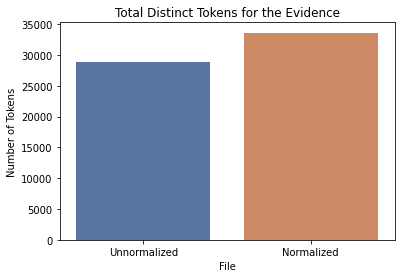

The reduction of tokens in the Claim was of 20.36 %


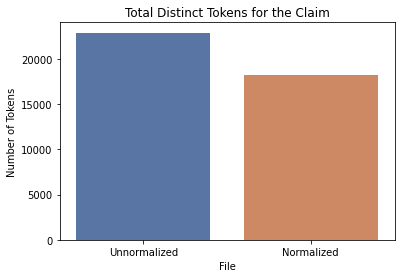

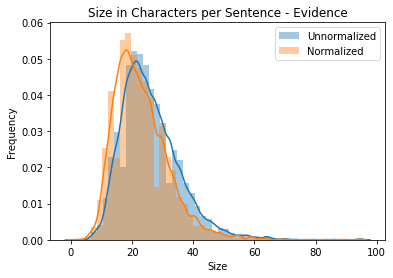

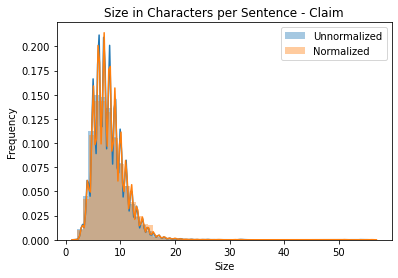

BEFORE PREPROCESSING
The vocabulary of evidence had: 33617 tokens
The vocabulary of claim had: 22883 tokens
The largest sample in the evidence had: 95 tokens
The largest sample in the claim had: 55 tokens

AFTER PREPROCESSING
The vocabulary of evidence has: 28938 tokens, was reduced in 13.92 %
The vocabulary of claim has: 18223 tokens , was reduced in 20.36 %
The largest sample in the evidence has: 94 tokens
The largest sample in the claim has: 56 tokens
Analysis completed!


In [ ]:
def get_vocabulary_corpus(corpus):
  vocabulary = set([elem for seq in corpus for elem in seq])
  return vocabulary

def get_uniq_tokens(text):
  return set([x for x in text])

# Before preprocessing
evidence_bfp = get_vocabulary_corpus(corpus_evidence_bfp)
claim_bfp = get_vocabulary_corpus(corpus_claim_bfp)
evidence_sentence_bfp = [len(get_uniq_tokens(x)) for x in corpus_evidence_bfp]
claim_sentence_bfp = [len(get_uniq_tokens(x)) for x in corpus_claim_bfp]
# After preprocessing
evidence_afp = get_vocabulary_corpus(df_train['evidence'])
claim_afp = get_vocabulary_corpus(df_train['claim'])
evidence_sentence_afp = [len(get_uniq_tokens(x)) for x in df_train['evidence']]
claim_sentence_afp = [len(get_uniq_tokens(x)) for x in df_train['claim']]

def num_distinct_tokens(text):
    tokens = text.split()
    dist_tokens = set()
    for token in tokens:
        dist_tokens.add(token)
    return len(dist_tokens)

print("---------------------------------------------")
print("\n\nStarting analysis of the preprocessing...")
#Total Number of Distinct Tokens for the Evidence
p_evid_reduction = 100* (len(evidence_bfp) - len(evidence_afp) )/ len(evidence_bfp) 
print("The reduction of tokens in the Evidence was of {:.2f} %".format(p_evid_reduction))
sns.barplot(x=["Unnormalized","Normalized"],y=[len(evidence_afp), len(evidence_bfp)], palette="deep")
plt.title('Total Distinct Tokens for the Evidence')
plt.xlabel('File')
plt.ylabel('Number of Tokens')
plt.show()

#Total Number of Distinct Tokens for the Claim
p_claim_reduction = 100* (len(claim_bfp) - len(claim_afp) )/ len(claim_bfp)
print("The reduction of tokens in the Claim was of {:.2f} %".format(p_claim_reduction))
sns.barplot(x=["Unnormalized","Normalized"],y=[len(claim_bfp), len(claim_afp)], palette="deep")
plt.title('Total Distinct Tokens for the Claim')
plt.xlabel('File')
plt.ylabel('Number of Tokens')
plt.show()

#Size of sentences for the Evidence
sns.distplot(evidence_sentence_bfp, label='Unnormalized')
sns.distplot(evidence_sentence_afp, label='Normalized')
plt.legend(loc='upper right')
plt.title('Size in Characters per Sentence - Evidence')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.show()
#Size of sentences for the Evidence
sns.distplot(claim_sentence_bfp, label='Unnormalized')
sns.distplot(claim_sentence_afp, label='Normalized')
plt.legend(loc='upper right')
plt.title('Size in Characters per Sentence - Claim')
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.show()

print("BEFORE PREPROCESSING")
print("The vocabulary of evidence had: {} tokens".format(len(evidence_bfp)))
print("The vocabulary of claim had: {} tokens".format(len(claim_bfp)))
print("The largest sample in the evidence had: {} tokens".format(max(evidence_sentence_bfp)))
print("The largest sample in the claim had: {} tokens".format(max(claim_sentence_bfp)))
print("\nAFTER PREPROCESSING")
print("The vocabulary of evidence has: {} tokens, was reduced in {:.2f} %".format(len(evidence_afp), p_evid_reduction))
print("The vocabulary of claim has: {} tokens , was reduced in {:.2f} %".format(len(claim_afp), p_claim_reduction))
print("The largest sample in the evidence has: {} tokens".format(max(evidence_sentence_afp)))
print("The largest sample in the claim has: {} tokens".format(max(claim_sentence_afp)))

print("Analysis completed!")

# Data Visualization

WordCloud of Supported Claims


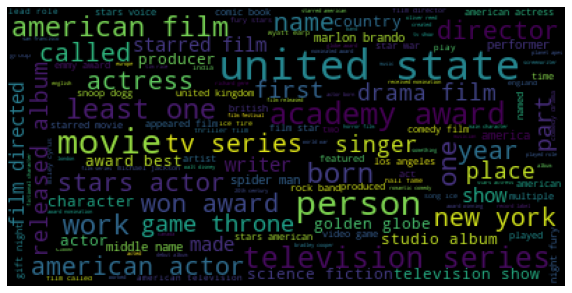



WordCloud of Refuted Claims


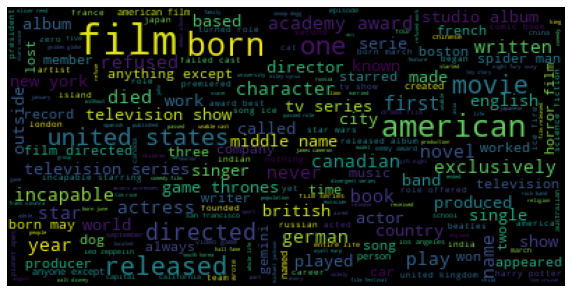

Dataframe structure:

Dataframe Columns: Index(['id', 'claim', 'evidence', 'id_claim', 'label'], dtype='object')

Total samples in train: 121707 - 89.45% of the whole data
Total samples in validation: 7165 - 5.27% of the whole data
Total samples in test: 7189 - 5.28% of the whole data

Some samples in train:   id                                              claim  ... id_claim     label
0  0  [chris, hemsworth, appeared, in, a, perfect, g...  ...        3  SUPPORTS
1  1                       [roald, dahl, is, a, writer]  ...        7  SUPPORTS
2  2                     [roald, dahl, is, a, governor]  ...        8   REFUTES
3  3  [ireland, has, relatively, low, lying, mountains]  ...        9  SUPPORTS
4  4  [ireland, does, not, have, relatively, low, ly...  ...       10   REFUTES

[5 rows x 5 columns]
Some samples in validation:   id                                              claim  ... id_claim     label
0  0  [the, indian, army, comprises, part, of, the, ...  ...    98304  SUPPORTS


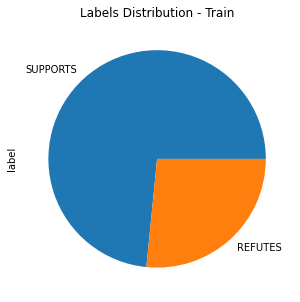

Distribution of Label in Validation: 
SUPPORTS    3611
REFUTES     3554
Name: label, dtype: int64


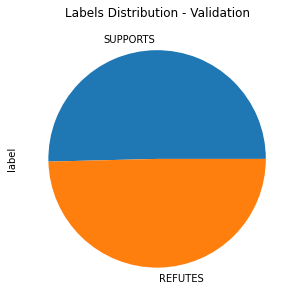

Distribution of Label in Test: 
SUPPORTS    3606
REFUTES     3583
Name: label, dtype: int64


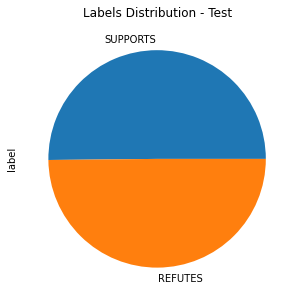

In [ ]:
#############################################################################
#               Data Visualization 
#############################################################################

def return_sentences(tokens):
    return " ".join([word for word in tokens])

# Word Cloud of Supported Claim

txt_claim = " ".join([x for x in df_train[df_train['label'] == 'SUPPORTS'].claim.apply(lambda x : return_sentences(x)) ])
txt_evidence = " ".join([x for x in df_train[df_train['label'] == 'SUPPORTS'].evidence.apply(lambda x : return_sentences(x)) ])

# Create and generate a word cloud image:
wordcloud_claim = WordCloud(max_font_size=30, max_words=1000).generate(txt_claim)
wordcloud_evidence = WordCloud(max_font_size=30, max_words=1000).generate(txt_evidence)

# Display the generated image:
print("WordCloud of Supported Claims")
plt.figure(figsize= [10,10])
plt.imshow(wordcloud_claim)
plt.axis("off")
plt.show()

###############

# Word Cloud of REFUTED Claim

txt_claim = " ".join([x for x in df_train[df_train['label'] == 'REFUTES'].claim.apply(lambda x : return_sentences(x)) ])
txt_evidence = " ".join([x for x in df_train[df_train['label'] == 'REFUTES'].evidence.apply(lambda x : return_sentences(x)) ])

# Create and generate a word cloud image:
wordcloud_claim = WordCloud(max_font_size=30, max_words=1000).generate(txt_claim)
wordcloud_evidence = WordCloud(max_font_size=30, max_words=1000).generate(txt_evidence)

# Display the generated image:
print("\n\nWordCloud of Refuted Claims")
plt.figure(figsize= [10,10])
plt.imshow(wordcloud_claim)
plt.axis("off")
plt.show()

# End of the Word Clouds

print("Dataframe structure:\n")
print("Dataframe Columns: {}".format(df_train.columns))
print()

print("Total samples in train: {} - {:.2f}% of the whole data".format(len(df_train),  100* (len(df_train)/ ( len(df_train) + len(df_val) + len(df_test)))))
print("Total samples in validation: {} - {:.2f}% of the whole data".format(len(df_val),  100* (len(df_val)/ ( len(df_train) + len(df_val) + len(df_test)))))
print("Total samples in test: {} - {:.2f}% of the whole data".format(len(df_test),  100* (len(df_test)/ ( len(df_train) + len(df_val) + len(df_test)))))
print()

print("Some samples in train: {}".format(df_train.head()))
print("Some samples in validation: {}".format(df_val.head()))
print("Some samples in test: {}".format(df_test.head()))
print()

# Some metrics

print("A short description of the labels: \n{}\n".format(df_train['label'].describe()))

print("Distribution of Label in Train: \n{}".format(df_train.label.value_counts()))
#print("\n{}".format(df_train['label'].hist(bins=6, alpha=0.5)))
# Plot of label for train
pd.Series(df_train['label']).value_counts().plot(
    kind='pie', title='Labels Distribution - Train', figsize=(5, 5))
plt.show()
print("Distribution of Label in Validation: \n{}".format(df_val.label.value_counts()))
#print("\n{}".format(df_val['label'].hist(bins=6, alpha=0.5, color='#86bf91')))
pd.Series(df_val['label']).value_counts().plot(
    kind='pie', title='Labels Distribution - Validation', figsize=(5, 5))
plt.show()
print("Distribution of Label in Test: \n{}".format(df_test.label.value_counts()))
#print("\n{}".format(df_test['label'].hist(bins=6, alpha=0.5, color='#00bf91')))
pd.Series(df_test['label']).value_counts().plot(
    kind='pie', title='Labels Distribution - Test', figsize=(5, 5))
plt.show()

# Data Balancing
After the visualization of the data, we could see that the train data is umbalanced with 89.389 samples for the label SUPPORT and just 32.351 for the REFUTES.
In the following section we will tray some functions to balance the data.

### Definition of the Functions
Below we defined 3 methods for resampling the data.<br>

Randon Undersampling: Undersample the majority class to the given samplesize <br>
Proportional Undersampling: Undersample the data considering the number of samples and the proportion <br>
Imblearn undersampling: Some functions of the Imblearn library

In [ ]:
# Some functions to downsample and balance the classes
# Some functions were based on [2], [3], [4]

#######################################################################
#                 Random Undersampling
#######################################################################

def random_undersampling(df, column, samplesize):
  '''
  This function downsample the df to the samplesize received
  Inputs:
  - df: dataframe
  - column: considered to apply the downsample
  - samplesize: final number of samples for each class of the column
  Output:
    -  the dataframe downsampled
  '''
  df_train_balanced = df.groupby(column, as_index=False).apply(lambda array: array.loc[np.random.choice(array.index, samplesize, False),:])
  df_train_balanced[column].hist()
  return df_train_balanced

#######################################################################
#               Proportional Undersampling
#######################################################################

def proportional_undersampling(df_train, column, proportion, n_items):
  '''
  def proportional_undersampling
  Inputs:
  - df_train: dataframe to be undersampled
  - proportion: to consider for the random undersampling
  - n_items: total of samples after the undersampling
  '''
  # Sorting the classes in a descendent way in order to have as first the class with majority
  u, count = np.unique(df_train[column], return_counts=True)
  count_sort_ind = np.argsort(-count)
  classes = u[count_sort_ind]
  n_class = [0, 0]

  # if the class with minority is inside the proportion
  # otherwise keep the same number of samples
  n_class[0] = int(np.floor( n_items * proportion))
  if n_items - n_class[0] <= df_train[column].value_counts().min():
    n_class[1] = n_items - n_class[0]
  else:
    n_class[1] = df_train[column].value_counts().min()

  df_train_balanced = pd.DataFrame()

  for i, c in enumerate(classes):
            tmp_idx = df_train[df_train.label == c].index.values.tolist()
            np.random.shuffle(tmp_idx)
            #tmp_idx = torch.from_numpy(tmp_idx)
            l_idx = tmp_idx[:n_class[i]]
            df_train_balanced = df_train_balanced.append( df_train.loc[l_idx] )

  return df_train_balanced

#######################################################################
#               Imblearn undersampling
#######################################################################

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids

# method = ['random', 'tomeklinks']
def imdb_undersampling(df_train, method = 'random'):
  X = df_train.copy()
  X = X[['id', 'id_claim'] ]
  X['len_claim'] = [len(x) for x in df_train.claim]
  X['len_evidence'] = [len(x) for x in df_train.evidence]

  y = df_train.copy()
  y = y['label']
  y = [1 if d == 'SUPPORTS' else 0 for i, d in enumerate(y) ]

  print("Features shape: {}".format(X.shape))
  print("Target shape: {}".format(len(y)))

  if method == 'random':
    # Imblearn undersampling random
    rus = RandomUnderSampler()
    X_d, y_d = rus.fit_sample(X, y)
  if method == 'tomeklinks':
    tl = TomekLinks(ratio='majority')
    X_d, y_d = tl.fit_sample(X, y)
  if method == 'centroid':
    cc = ClusterCentroids(sampling_strategy=1/2, random_state=42, voting= 'soft')
    X_d, y_d = cc.fit_sample(X, y)
  l_id = [int(row[0]) for row in X_d]

  # Undersampling the df
  df_train_balanced = df_train.copy()
  df_train_balanced = df_train_balanced.loc[l_id]

  print("\nDistribution without undersampling: \n{}".format(df_train.label.value_counts()))
  print("\n{}".format(df_train['label'].hist(bins=4, alpha=0.5)))

  print("Distribution with undersampling: \n{}".format(df_train_balanced.label.value_counts()))
  print("\n{}".format(df_train_balanced['label'].hist(bins=4, alpha=0.5)))

  return df_train_balanced


### Applying Undersample

A short description of the labels: 
count       64688
unique          2
top       REFUTES
freq        32344
Name: label, dtype: object

Distribution of Label in Train: 
REFUTES     32344
SUPPORTS    32344
Name: label, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


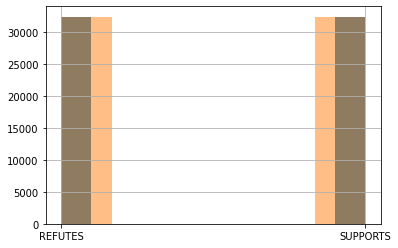

In [ ]:
'''
IN the cell above were defined 3 functions for doing the undersample
Feel free to try them below uncommenting their corresponding code
'''
# Applying the proportional undersampling
#df_train_balanced = proportional_undersampling(df_train, 'label' ,0.50, 60000)

# Uncomment to apply the random undersampling
min_samplesize = df_train.label.value_counts().values.min()
df_train_balanced = random_undersampling(df_train, 'label', min_samplesize)

# Uncomment to try the methods of Imblearn undersampling
#df_train_balanced = imdb_undersampling(df_train, method = 'tomeklinks')

# Visualizing the results
print("A short description of the labels: \n{}\n".format(df_train_balanced['label'].describe()))
print("Distribution of Label in Train: \n{}".format(df_train_balanced.label.value_counts()))
print("\n{}".format(df_train_balanced['label'].hist(bins=6, alpha=0.5)))


#Uncomment to work with unsampled data
#df_train = df_train_balanced

# Encoding the Dataset
In this section we can encode the claim and evidencens with glove, word2vec and fasttext.
Feel free to run the section of the encoding of your preference.

### Encoding the Labels

In [ ]:
#Encode the labels
#PAD = '<PAD>'
#labels = [PAD,'SUPPORTS','REFUTES']
labels = ['SUPPORTS','REFUTES']
#encoding_to_label = {1:'SUPPORTS', 2:'REFUTES'}
encoding_to_label = dict(enumerate(labels))
label_to_encoding = {label:enc for enc,label in encoding_to_label.items()}

print('label_to_encoding:')
print(label_to_encoding)
print('\nencoding_to_label:')
print(encoding_to_label)

label_to_encoding:
{'SUPPORTS': 0, 'REFUTES': 1}

encoding_to_label:
{0: 'SUPPORTS', 1: 'REFUTES'}


### Encoding with Glove / Word2Vec
Run the code below to encode the claim and evidence with glove or word2vec.

#### Encoding Claims and Evidences

In [ ]:
import gensim
import gensim.downloader as gloader
from pathlib import Path

def get_embedding_model_download_path(model_type, embedding_dim):
    """
    Parameters
    ----------
        model_type: str
            Name of the embedding model.
        embedding_dim: int
            Dimension of the embeddings in the embedding model.
    Returns
    -------
        The path to download the model.
    """
    download_path = ""

    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dim)

    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove")

    return download_path
    

def load_embedding_model(model_type, embedding_dim):
    """
    Loads a pre-trained word embedding model via gensim library.

    Parameters
    ----------
        model_type : str
            Embedding model to download.
        embedding_dim : int
            Size of the embedding space to consider.

    Returns
    -------
        emb_model : gensim.models.keyedvectors.KeyedVectors
            Pre-trained word embedding model.
    """

    # Find the correct embedding model name
    
    download_path = get_embedding_model_download_path(model_type, embedding_dim)

    #Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        if model_type.strip().lower() == 'word2vec':
            print("Word2Vec: 300")
        if model_type.strip().lower() == 'glove':
            print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model


#Supported embedding dimensions:
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
model_type = 'GloVe'
embedding_dim = 300

embedding_folder = os.path.join(os.getcwd(), 'Embeddings')
Path(embedding_folder).mkdir(parents=True, exist_ok=True)

model_path = get_embedding_model_download_path(model_type, embedding_dim)
embedding_path = os.path.join(embedding_folder,model_path)

#When the embedding model is downloaded save it to memory so that if the cell is
#re-executed it's not needed to download it again
if not os.path.exists(embedding_path):
    print('Downloading {} ...'.format(model_path))
    embedding_model = load_embedding_model(model_type, embedding_dim)
    print('\nSaving the model to memory ...')
    os.mknod(os.path.join(embedding_folder,'{}.vectors.npy'.format(model_path)))
    embedding_model.save(embedding_path)
    print('Done')
else:
    print('The requested GloVe embedding model has already been downloaded')
    print('Loading {} ...'.format(model_path))
    embedding_model = gensim.models.KeyedVectors.load(embedding_path)

In [ ]:
def get_embeddings(df, embedding_model, embedding_dim):
    """
    Retrieve for each token present in df its embedding taking it either from
    the embedding model or, in case there are tokens not present in the previous two vocabularies,
    generating it randomically.

    Parameters
    ----------
        df : pandas.DataFrame
            DataFrame which will be used to create the vocabulary. Each token
            of the vocabulary will be then associated with an embedding.
        embedding_model : gensim.models.keyedvectors.KeyedVectors
            Dictionary-like structure that contains words embedding.
        embedding_dim : int

    Returns
    -------
        embeddings : dict
            The embeddings of the tokens presents in the vocabulary generated
            by df.
    """
    vocabulary = set([elem for seq in pd.concat([df['claim'],df['evidence']]) for elem in seq])

    #Out of vocabulary tokens
    OOV_tokens = [token for token in vocabulary if token.lower() not in embedding_model]

    #Build OOV embeddings without the co-occurrence matrix
    embeddings_oov = {token:np.random.normal(size=embedding_dim) \
                      for token in OOV_tokens}

    embeddings = {**embedding_model, **embeddings_oov}

    return embeddings

In [ ]:
#Encode padding
#embedding_model[PAD] = np.zeros(embedding_dim)

#Creation of the training set's embeddings
embeddings_train = get_embeddings(df=df_train,
                                  embedding_model={key:embedding_model[key] for key in embedding_model.vocab.keys()},
                                  embedding_dim=embedding_dim)

#Creation of the validation set's embeddings
embeddings_val = get_embeddings(df=df_val,
                                embedding_model=embeddings_train,
                                embedding_dim=embedding_dim)

#Creation of the test set's embeddings
embeddings_test = get_embeddings(df=df_test,
                                 embedding_model=embeddings_val,
                                 embedding_dim=embedding_dim)

In [ ]:
# Checking the OOVs

vocabulary = set([elem for seq in pd.concat([df_train['claim'], df_train['evidence']]) for elem in seq])
embedding_model_2={key:embedding_model[key] for key in embedding_model.vocab.keys()}

#Out of vocabulary tokens
OOV_tokens = [token for token in vocabulary if token.lower() not in embedding_model_2]

print('OOVS {} - {:2f}%'.format(len(OOV_tokens),   100* len(OOV_tokens)/ len(vocabulary) ) )
print(OOV_tokens)

OOVS 2458 - 7.840010%
['federatsii', 'elflman', '1946september', 'supraregional', 'transluminal', 'shophe', 'wwfwwe', 'owuo', 'iteru', 'telanovela', 'athnai', 'donalbain', 'chrononauts', 'bandamax', 'varayev', 'commisar', 'sily', 'productionsongwriting', 'johnt', 'virginiaplaintiffs', 'sarcoptes', 'injans', 'wildings', '33million', 'lubnn', '513000', 'febreuary', 'iridioides', 'georgeville', 'rivele', 'simza', 'vocalistaccordionist', 'hulandes', 'chymist', 'charactersrichard', 'brche', 'lymelife', 'nitroplus', 'damnesia', 'veeraiya', 'teavana', 'antiheroic', 'suseenthiran', 'yakthung', 'dolcefino', 'zootropolis', 'gaarjya', 'vended', 'dpartements', 'actionanimated', 'delevingne', 'graceffa', 'hickenbottom', 'romelle', 'greeance', 'qubool', 'willkapampa', 'pashtodari', 'agrotera', 'wechat', '348347', 'etpt', 'nutsa', 'mcmary', 'muthucharam', 'ubertov', 'szeles', 'dhill', 'kukhianidze', 'baahubali', 'experimentalelectronic', 'chainsmokers', 'tunt', 'gonzlez', 'writerproducer', 'urundi', 

### Encoding with Fasttet






#### Encoding Claims and Evidences
The creation of the embeddings was done offline, locally in our pc and the resultings embeddings were uploaded to google drive as JSON files.

The code below was used for the creations of the embeddings.


```
# This is formatted as code

# To consider Fasttext as encoding model we based on [6][7]

###########################################
# Installing fasttext
###########################################
! pip install pytorch-nlp
from torchnlp.word_to_vector import FastText  # doctest: +SKIP
vectors = FastText(cache='cache')  # doctest: +SKIP
embedding_dim = 300

###########################################
# Creating the embeddings 
###########################################

def get_embeddings_fasttext(df, embedding_fasttext, embedding_ref, embedding_dim):
    vocabulary = set([elem for seq in pd.concat([df['claim'],df['evidence']]) for elem in seq])
    OOV_tokens = []
    if embedding_ref != None:
        OOV_tokens = [token for token in vocabulary if token.lower() not in embedding_ref]
        embedding_model={key:embedding_fasttext[key].tolist() for key in OOV_tokens}
        embedding_model = {**embedding_model, **embedding_ref}
    else:   
        # only train
        embedding_model= {key:embedding_fasttext[key].tolist() for key in vocabulary}        
    return embedding_model


#Creation of the training set's embeddings
embeddings_train = get_embeddings_fasttext(df=df_train, embedding_fasttext = vectors,
                                  embedding_ref=None,
                                  embedding_dim=embedding_dim)

#Creation of the validation set's embeddings
embeddings_val = get_embeddings_fasttext(df=df_val, embedding_fasttext = vectors,
                                embedding_ref=embeddings_train,
                                embedding_dim=embedding_dim)

#Creation of the test set's embeddings
embeddings_test = get_embeddings_fasttext(df=df_test, embedding_fasttext = vectors,
                                 embedding_ref=embeddings_val,
                                 embedding_dim=embedding_dim)

########################################
# Saving the embeddings as JSON files
########################################
import json

with open('emb_train.json', 'w') as fp:
    json.dump(embeddings_train, fp)
    
with open('emb_val.json', 'w') as fp:
    json.dump(embeddings_val, fp)
    
with open('emb_test.json', 'w') as fp:
    json.dump(embeddings_test, fp)
```



In [ ]:
#########################################
#             FASTTEXT 
#########################################
'''
Since for problems of memory and also storage we could not create the embeddings with
Fasttext here in colab, we proceeded to do it locally in our pc, so we created 
the embeddings for each split and uploaded them to Google drive as JSON files.
'''

# Loading fasttext prebuilt embeddings 
!pip install gdown

# Downloading the embeddings from google drive

!gdown https://drive.google.com/u/0/uc?id=1P0odOcRB7I-nXWYauTC_7Zv8oge9G5rl&export=download
!gdown https://drive.google.com/u/0/uc?id=1t89TiBkM-owAeE8pNiCujnVQv9Dm_rrQ&export=download
!gdown https://drive.google.com/u/0/uc?id=1YovBEc85qWb2jxbOBDNm6loKLt18LLEu&export=download


# Loading Fasttext embeddings

embedding_dim = 300

embeddings_train = json.loads(open('emb_train_con_num.json' , 'r').read())
embeddings_val = json.loads(open('emb_val_con_num.json' , 'r').read())
embeddings_test = json.loads(open('emb_test_con_num.json' , 'r').read())

Downloading...
From: https://drive.google.com/u/0/uc?id=1P0odOcRB7I-nXWYauTC_7Zv8oge9G5rl
To: /content/emb_train_con_num.json
189MB [00:02, 69.6MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1t89TiBkM-owAeE8pNiCujnVQv9Dm_rrQ
To: /content/emb_val_con_num.json
198MB [00:02, 74.2MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1YovBEc85qWb2jxbOBDNm6loKLt18LLEu
To: /content/emb_test_con_num.json
208MB [00:02, 79.3MB/s]


# Dataset and Batch Loaders

### Dataset class
The `Dataset` class will be used by the `DataLoader` in order to iterate over data during the training / evaluation phase.

In [ ]:
class Dataset(torch.utils.data.Dataset):
    """
    Handles the data.
    It has two main tasks: encode the data and load it on tensors and, if it is
    required, transfer it to the device memory.

    Attributes
    ----------
        data : list of dict
            Contains the (encoded) data of the dataset. Each element of the list is a
            dictionary that contains as many elements as the number of columns
            of the preprocessed DataFrame (by means of the initialization parameters
            selected_columns and excluded_columns) passed to the initialization function.
            Each element of the dictionary contains a tensor allocated on the
            given device.
        encoders : dict of dict
            Each element of the dictionary contains an encoder (which is itself
            a dictionary) for a column of the dataset.
        device : torch.device
            Device to transfer the tensors to (the ones present in the attribute
            data)

    Methods
    -------
        shuffle():
            Shuffle the data present in the attribute data.
    """
    def __init__(self, df, input_columns, label_column, index_column, encoders, device=torch.device('cpu')):
        """
        Makes use of the DataFrame to build the data.
        In particular the DataFrame gets preprocessed by means of selected_columns
        and excluded_columns and then each row of the remaining DataFrame gets
        inserted in the data by transforming each of its row in a dictionary
        containing at each key the DataFrame's column's content casted to a tensor
        which is then moved of the specified device.

        Parameters
        ----------
            df : DataFrame
                DataFrame over which the dataset will be built.
            input_columns : list of str
            label_column : str
            index_column : str
            encoders : dict of dict
                It'a dictionary that have as keys the columns of the DataFrame
                and hold the encoders for each column.
            device : torch.device, torch.device('cpu') by default
                Device where the dataset will be placed to.
        """
        self.encoders = encoders
        self.device = device

        df = df[input_columns+[label_column]+[index_column]]

        #Encode the data and store it on the given device
        self.data = [{col : torch.tensor(int(row[col]) if col==index_column #index column
                                         else self.encoders[col][row[col]] if col==label_column #label column
                                         else [self.encoders[col][elem] for elem in row[col]], #input columns
                                         dtype=torch.double if col in input_columns else torch.long,
                                         device=self.device, requires_grad=False) \
                      for col in df.columns} \
                     for idx, row in tqdm(df.iterrows(), total=df.shape[0])]

        

    def shuffle(self):
        """
        Shuffle data.
        """
        random.shuffle(self.data)
    def __len__(self):
        """
        Returns the length of data.
        """
        return len(self.data)
#        return self.len_data
    def __getitem__(self, idx):
        """
        Get the item at the given index

        Parameters
        ----------
            idx : int
                Index of the object contained in data that has to be returned
        Returns
        -------
            element : dict
                The element of data at idx
        """
        return self.data[idx]
#        return {col:self.data[col][idx] for col in self.data.keys()}

In [ ]:
if 'training_dataset' in globals():
    print('Deallocating training_dataset ...')
    del training_dataset
    gc.collect()
    time.sleep(10.)
    print('Done\n')

if 'validation_dataset' in globals():
    print('Deallocating validation_dataset ...')
    del validation_dataset
    gc.collect()
    time.sleep(10.)
    print('Done\n')

if 'test_dataset' in globals():
    print('Deallocating test_dataset ...')
    del test_dataset
    gc.collect()
    time.sleep(10.)
    print('Done\n')


print('Preparing training set ...')
training_dataset = Dataset(df_train,
                           input_columns = ['claim', 'evidence'],
                           label_column = 'label',
                           index_column='id_claim',
                           encoders={'claim':embeddings_train, 'evidence':embeddings_train, 'label':label_to_encoding},
                           device=device)
print('Done\n')
print('Preparing validation set ...')
validation_dataset = Dataset(df_val,
                             input_columns = ['claim', 'evidence'],
                             label_column = 'label',
                             index_column='id_claim',
                             encoders={'claim':embeddings_val, 'evidence':embeddings_val, 'label':label_to_encoding},
                             device=device)
print('Done\n')
print('Preparing test set ...')
test_dataset = Dataset(df_test,
                       input_columns = ['claim', 'evidence'],
                       label_column = 'label',
                       index_column='id_claim',
                       encoders={'claim':embeddings_test, 'evidence':embeddings_test, 'label':label_to_encoding},
                       device=device)
print('Done')

Preparing training set ...



Done

Preparing validation set ...



Done

Preparing test set ...



Done


### BatchBuilder class
The `BatchBuilder` class will be used to act as `collate_fn` parameter of the DataLoader class.<br>
Its aim is to stack the data retrieved from a dataset by column and to pad it by the length of the longest sequence present in the batch.

In [ ]:
#This class will be passed to the DataLoader as collate_fn to build the batches
class BatchBuilder(object):
    """
    Implements the batching function.
    Starting from a list of Dataset's elements it builds a padded batch.

    Attributes
    ----------
        input_columns: list of str
            Name of the input columns.
        label_column: str
            Name of the label's column.
        index_column: str
            Name of the column that holds the indices used to univocally identify
            the samples.
    Methods
    -------
        __call__(batch) :
            Implements the actual batching function.
    """
    def __init__(self, input_columns, label_column, index_column):
        self.input_columns = input_columns
        self.label_column = label_column
        self.index_column = index_column

    def __call__(self, batch):
        """
        Implements the collate_fn function.
        It has as parameter a list of elements of the class Dataset.
        For each batch the length of each elements gets padded to the length
        of the element of the maximum length within the same batch.

        Parameters
        ----------
            batch : list of dict
        Returns
        -------
            packed_batch : torch.nn.utils.rnn.PackedSequence
               packed batch.
        """
        packed_batch = {col: torch.nn.utils.rnn.pack_sequence([elem[col] for elem in batch], enforce_sorted=False) \
                        for col in self.input_columns}
        
        packed_batch[self.label_column] = torch.stack([elem[self.label_column] for elem in batch]).view(-1,1)
        packed_batch[self.index_column] = torch.stack([elem[self.index_column] for elem in batch]).view(-1,1)

        return packed_batch

In [ ]:
batch_size = 128

#Maximum number of tokens in both claim and evidence
max_tokens = max([row[col].shape[0] for row in training_dataset.data+validation_dataset.data+test_dataset.data for col in ['claim','evidence']])


batch_builder = BatchBuilder(input_columns=['claim','evidence'],
                             label_column='label',
                             index_column='id_claim')


train_batches = torch.utils.data.DataLoader(training_dataset,
                                            batch_size=batch_size,
                                            shuffle=True,
                                            collate_fn=batch_builder)

val_batches = torch.utils.data.DataLoader(validation_dataset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=batch_builder)

test_batches = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           collate_fn=batch_builder)

# Training Functionalities

### Training Class

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

class Train():
    """
    Implementation of the training loop

    Attributes
    ----------
        model : torch.nn.Module
        loss_function : torch.nn.Module
        optimizer : torch.optim.Optimizer
        lr_scheduler : torch.optim.lr_scheduler._LRScheduler or object, None by default
        lt_scheduler_metric : bool, False by default
            If true then the validation loss is passed to the lr_scheduler as metric.
        state_path : str, 'Assignment3-model.pt' by default
            The path where to save the model's state.
        return_best_model : bool, True by default
            If true before the ending of the training loop function gets loaded
            in memory the model with the best configuration found so far.

    Methods
    -------
        epoch_time(start_time, end_time):
            Prints the elapsed time between the start of the epoch and its end.
        train(iterator, is_train=True):
            Training function.
        evaluate(iterator):
            Evaluation function.
        save_state():
            Save the state of the training.
        load_state(load_model_only=False):
            Load the last saved state of the training.
        get_measurements(labels, predictions, set_label):
            Compute accuracy, f1-macro, precision and recall between labels and
            predictions.
        get_compound_labels_and_predictions(id_claim, labels, predictions):
            Groups instances holding the same id_claim
        __call__(train_iterator, valid_iterator, verbose=True):
            Implementation of the training loop.
    """
    measurements = ['acc', 'f1', 'recall', 'precision']

    def __init__(self, model, loss_function, optimizer, lr_scheduler=None, lr_scheduler_metric=False,
                 state_path='Assignment3-model.pt', return_best_model=True):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_metric = lr_scheduler_metric
        self.state_path = state_path
        self.return_best_model = return_best_model


    def epoch_time(self, start_time, end_time):
        """
        Compute the elapsed time between two given measurements.

        Parameters
        ----------
            start_time
                Beginning of the measurament.
            end_time
                Ending of the measurament.
        Returns
        -------
            elapsed_mins :
                Elapsed minutes.
            elapsed_secs :
                Elapsed seconds.

        """
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs


    def train(self, iterator, is_train=True):
        """
        Training function which has been adapted to be used also for
        validation.

        Parameters
        ----------
            iterator: SimpleIterator
                Dataset on which perform the training / validation.
            is_train : bool, True by default

        Returns
        -------
            Loss, labels, prediction and indices of the input.
        """
        labels_epoch = []
        predictions_epoch = []
        id_claim_epoch = []

        epoch_loss = 0
        
        if is_train:
            self.model.train()
        else:
            self.model.eval()

        with torch.set_grad_enabled(is_train):
            for batch in tqdm(iterator):
                claim = batch['claim']
                evidence = batch['evidence']
                label = batch['label']
                id_claim = batch['id_claim']
                
                if is_train:
                    self.optimizer.zero_grad()
                
                #[batch_size, num_classes]
                predictions = self.model(claim, evidence)
                
                #[batch_size]
                labels_epoch.append(label.view(-1))
                predictions_epoch.append(predictions.argmax(dim=1).view(-1))
                id_claim_epoch.append(id_claim.view(-1))
                
                loss = self.loss_function(predictions, label.view(-1))
                
                if is_train:
                    loss.backward()
                    self.optimizer.step()
                
                epoch_loss += loss.item()

            
        return epoch_loss / len(iterator), torch.cat(labels_epoch), \
               torch.cat(predictions_epoch), torch.cat(id_claim_epoch)


    def evaluate(self, iterator):
        """
        Compute the loss and accuracy over the validation set.

        Parameters
        ----------
            iterator : SimpleIterator
                Dataset on which perform the validation.
        Returns
        -------
            Loss, labels, prediction and indices of the input.
        """
        return self.train(iterator, is_train=False)

    def save_state(self):
        """
        Save the current state of the training procedure.
        """
        torch.save({'model_state_dict':self.model.state_dict(),
                    'optimizer_state_dict':self.optimizer.state_dict(),
                    'lr_scheduler_state_dict':self.lr_scheduler.state_dict() if self.lr_scheduler is not None else None,
                    'best_epoch':self.best_epoch,
                    'best_valid_acc':self.best_valid_acc,
                    }, self.state_path)
        
    def load_state(self, load_model_only=False):
        """
        Load the last saved training's state.

        Parameters
        ----------
            load_model_only : bool, False by default
                If True it will be loaded only the model, the best_epoch and
                the best valid_accuracy (The latter 2 only for visualization purposes).
        """
        checkpoint = torch.load(self.state_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.best_epoch = checkpoint['best_epoch']
        self.best_valid_acc = checkpoint['best_valid_acc']

        if load_model_only:
            return

        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if self.lr_scheduler is not None:
            self.lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

        self.train_loss_history = self.train_loss_history[:self.best_epoch+1]
        self.valid_loss_history = self.valid_loss_history[:self.best_epoch+1]
        self.train_measurements = self.train_measurements[:self.best_epoch+1]
        self.valid_measurements = self.valid_measurements[:self.best_epoch+1]
        self.train_measurements_comp = self.train_measurements_comp[:self.best_epoch+1]
        self.valid_measurements_comp = self.valid_measurements_comp[:self.best_epoch+1]


    def get_measurements(self, labels, predictions, set_label):
        """
        Compute accuracy, f1-macro, precision and recall between labels and
        predictions.

        Parameters
        ----------
            labels : numpy.ndarray
            predictons : numpy.ndarray
            set_label : str
                String used to identify the name of the set which labels and
                predictions belong to (used for printing).
        Returns
        -------
            Dictionary containing accuracy, f1-macro, recall and precision
        """
        #accuracy
        acc = accuracy_score(labels, predictions)
        #f1
        f1 = f1_score(labels, predictions, average='macro')
        #recall
        recall = recall_score(labels, predictions, average='macro')
        #precision
        precision = precision_score(labels, predictions, average='macro')

        print(f'\t{set_label} Acc: {acc*100:.2f}% | {set_label} F1: {f1:.3f} | '\
                f'{set_label} Rec: {recall:.3f} | {set_label} Prec: {precision:.3f}')

        return {key:val for key,val in zip(Train.measurements, [acc, f1, recall, precision])}


    def get_compound_labels_and_predictions(self, id_claim, labels, predictions):
        """
        Group by labels and predictions according to id_claim

        Parameters
        ----------
            id_claim : numpy.ndarray
            labels : numpy.ndarray
            predictons : numpy.ndarray
        Returns
        -------
            Grouped labels and predictions
        """
        group = np.concatenate([id_claim[:,None], labels[:,None], predictions[:,None]], axis=1)
        group= group[np.argsort(group[:,0]),:]
        group = np.split(group[:,1:], np.unique(group[:,0], return_index=True)[1][1:])

        grouped_labels = [preds_group[0][0] for preds_group in group]
        voting = [max(sorted(list(set([p for _,p in preds_group]))), key=[p for _,p in preds_group].count)
                  for preds_group in group]

        return grouped_labels, voting


    def __call__(self, num_epochs, train_iterator, valid_iterator, init_model=True):
        """
        Implementation of the training loop.

        Parameters
        ----------
            num_epochs : int
            train_iterator : SimpleIterator
                Iterator containing the training data.
            valid_iterator : SimpleItarator
                Iterator containing the validation data.
            init_model : bool, True by default
                If True the model gets initialized before the execution of the training loop.
        """
        if init_model:
            print('Parameters Initialization ...')
            self.model.init_params()
            print('Done\n')

        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator

        self.labels_train, self.predictions_train, self.labels_valid, self.predictions_valid = [],[],[],[]

        print('Best validation accuracy initialization ...')
        _, labels_valid, predictions_valid, _ = self.evaluate(valid_iterator)
        self.best_valid_acc = accuracy_score(labels_valid.cpu().detach().numpy(),
                                             predictions_valid.cpu().detach().numpy())
        print('Done\n')
        self.best_epoch = -1

        self.train_loss_history, self.valid_loss_history = [],[]
        self.train_measurements, self.valid_measurements = [],[]
        self.train_measurements_comp, self.valid_measurements_comp = [],[]

        #Save the initial state
        self.save_state()

        try:
            print('Beginning training procedure\n')
            for epoch in range(num_epochs):

                start_time = time.time()
                
                train_loss, labels_train, predictions_train, id_claim_train = self.train(train_iterator)
                valid_loss, labels_valid, predictions_valid, id_claim_valid = self.evaluate(valid_iterator)
                
                end_time = time.time()

                epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)


                #measurements:
                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
                print(f'\tTrain Loss: {train_loss:.3f}')
                print(f'\tValid Loss: {valid_loss:.3f}')


                labels_train = labels_train.cpu().detach().numpy()
                predictions_train = predictions_train.cpu().detach().numpy()
                labels_valid = labels_valid.cpu().detach().numpy()
                predictions_valid = predictions_valid.cpu().detach().numpy()
                id_claim_train = id_claim_train.cpu().detach().numpy()
                id_claim_valid = id_claim_valid.cpu().detach().numpy()

                print(f'Normal measurements:')
                self.train_measurements.append(self.get_measurements(labels_train, predictions_train, 'Train'))
                self.valid_measurements.append(self.get_measurements(labels_valid, predictions_valid, 'Valid'))

                valid_acc = self.valid_measurements[-1]['acc']


                grouped_train_labels, train_voting = self.get_compound_labels_and_predictions(id_claim_train, labels_train, predictions_train)
                grouped_valid_labels, valid_voting = self.get_compound_labels_and_predictions(id_claim_valid, labels_valid, predictions_valid)

                print(f'Compound measurements:')
                self.train_measurements_comp.append(self.get_measurements(grouped_train_labels, train_voting, 'Train'))
                self.valid_measurements_comp.append(self.get_measurements(grouped_valid_labels, valid_voting, 'Valid'))


                if valid_acc > self.best_valid_acc:
                    self.best_valid_acc = valid_acc
                    self.best_epoch = epoch
                    #Save the training state corresponding to the best prediction
                    #found so far
                    self.save_state()

                #Update the learining rate
                if self.lr_scheduler is not None:
                    current_lr = self.optimizer.param_groups[0]['lr']
                    if not self.lr_scheduler_metric:
                        self.lr_scheduler.step()
                    else:
                        self.lr_scheduler.step(valid_acc)
                    next_lr = self.optimizer.param_groups[0]['lr']
                    print(f'lr: {current_lr} --> {next_lr}')

                self.train_loss_history.append(train_loss)
                self.valid_loss_history.append(valid_loss)

        #In case the execution gets interrupted before its natural ending the last
        #saved training's state will be loaded into memory
        except KeyboardInterrupt:
            print('\n\nExecution Interrupted')
            print('Resuming from the previous best epoch ...')
            self.load_state()
            print('Loaded model at epoch {}, and with validation accuracy of {}%'.format(self.best_epoch+1,self.best_valid_acc*100))

        else:
            #If self.return_best_model is True then at the end of the execution of the training loop
            #it will be loaded on the model the best found one during the training procedure.
            if self.return_best_model:
                print('\n\nLoading the model with the best validation accuracy ...')
                self.load_state(load_model_only=True)
                print('Model loaded with results of epoch {} and with validation accuracy of {}%'.format(self.best_epoch+1,self.best_valid_acc*100))

        #Remove the folder where the training state is located
        os.remove(self.state_path)


    def plot(self, ax, x, y_train, y_valid, title):
        ax.plot(x, y_train, label='training')
        ax.plot(x, y_valid, label='validation')
        ax.legend()
        try:
            ax.xlabel('epoch')
            ax.ylabel(title.lower())
            ax.title(title)
        except:
            ax.set_xlabel('epoch')
            ax.set_ylabel(title.lower())
            ax.set_title(title)
        

    def display_results(self):
        """
        Plot the history of the loss, accuracy, f1-macro, precision and recall
        (both as normal measurements and the grouped one).
        """
        print('\nBest validation accuracy found at epoch {}: {:.4f}%'.format(self.best_epoch+1,self.best_valid_acc*100))

        plt.figure()
        self.plot(plt, list(range(len(self.train_loss_history))),
                  self.train_loss_history, self.valid_loss_history,
                  title='Loss')
        plt.show()


        num_epochs_ax = list(range(len(self.train_measurements)))

        print('\nNormal measurements')
        train_measurements ={col:[em[col] for em in self.train_measurements] for col in Train.measurements}
        valid_measurements ={col:[em[col] for em in self.valid_measurements] for col in Train.measurements}

        fig, ((ax_acc, ax_f1),(ax_rec, ax_prec)) = plt.subplots(2, 2, figsize=(13.3, 9.0))
        self.plot(ax_acc, num_epochs_ax,
                  train_measurements['acc'], valid_measurements['acc'],
                  title='Accuracy')
        self.plot(ax_f1, num_epochs_ax,
                  train_measurements['f1'], valid_measurements['f1'],
                  title='F1-macro')
        self.plot(ax_rec, num_epochs_ax,
                  train_measurements['recall'], valid_measurements['recall'],
                  title='Recall')
        self.plot(ax_prec, num_epochs_ax,
                  train_measurements['precision'], valid_measurements['precision'],
                  title='Precision')
        plt.show()

        print('\nCompound measurements')
        train_measurements_comp ={col:[em[col] for em in self.train_measurements_comp] for col in Train.measurements}
        valid_measurements_comp ={col:[em[col] for em in self.valid_measurements_comp] for col in Train.measurements}

        fig, ((ax_acc_comp, ax_f1_comp),(ax_rec_comp, ax_prec_comp)) = plt.subplots(2, 2, figsize=(13.3, 9.0))
        self.plot(ax_acc_comp, num_epochs_ax,
                  train_measurements_comp['acc'], valid_measurements_comp['acc'],
                  title='Accuracy')
        self.plot(ax_f1_comp, num_epochs_ax,
                  train_measurements_comp['f1'], valid_measurements_comp['f1'],
                  title='F1-macro')
        self.plot(ax_rec_comp, num_epochs_ax,
                  train_measurements_comp['recall'], valid_measurements_comp['recall'],
                  title='Recall')
        self.plot(ax_prec_comp, num_epochs_ax,
                  train_measurements_comp['precision'], valid_measurements_comp['precision'],
                  title='Precision')
        plt.show()

### Loss Function

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

#If GPU is present transfer the loss function on it
if torch.cuda.is_available():
    print('Loss Function to GPU')
    loss_function.to(device)

Loss Function to GPU


#Architectures

### Base Architectures

In [ ]:
class BaseNN(torch.nn.Module):
    """
    Defines merging procedure for the claim and evidence's sentence encoding
    and also the final fully connected layer.
    """
    merging_strategy_values = ['concat','sum','mean']

    def __init__(self, num_features, output_dim, merging_strategy, compute_cosine_similarity=False, dropout=0.0, device=torch.device('cpu')):
        """
        Initialization procedure.

        Parameters
        ----------
            num_features : int
                The sentence's embedding dimension of claim and evidence.
            output_dim : int
                Number of class to be predicted (2 in our case).
            merging_strategy : str
                One of 'concat', 'sum' or 'mean'.
            compute_cosine_similarity : bool, False by default
                If True computes and pass to the final FC layer the cosine
                similarity between claim and evidence sentence's embedding.
            dropout : int, 0.0 by default
                Dropout to be applied before the final FC layer.
            device : torch.device
                Device where the computation takes place.
        """
        super(BaseNN,self).__init__()

        if merging_strategy not in BaseNN.merging_strategy_values:
            raise ValueError('The merging strategy should be one of the following: {}'.format(BaseNN.merging_strategy_values))
        self.merging_strategy = merging_strategy

        self.compute_cosine_similarity = compute_cosine_similarity
        if self.compute_cosine_similarity:
            self.cosine_similarity = torch.nn.CosineSimilarity()

        self.dropout = torch.nn.Dropout(dropout)

        self.num_features = num_features
        self.fc_input_dim = self.num_features*2 if self.merging_strategy=='concat' else self.num_features
        self.fc_input_dim = self.fc_input_dim+1 if self.compute_cosine_similarity else self.fc_input_dim
        #LayerNorm
        self.layer_norm = torch.nn.GroupNorm(1,self.fc_input_dim)
        #Fully connected layer
        self.fc = torch.nn.Linear(self.fc_input_dim, output_dim)

        self.device = device


    def end_init(self):
        self.init_params()
        self = self.double()
        self.to(self.device)

    def init_f(self, x):
        """
        Function used by init_param to initialize the parameters.
        """
        for name, param in x.named_parameters():
            try:
                torch.nn.init.orthogonal_(param.data)
            except ValueError:
                torch.nn.init.normal_(param.data, mean = 0, std = 0.1)

    def init_params(self):
        """
        Initialize the model's parameters.
        """
        self.apply(self.init_f)


    def get_encodings(self, claim, evidence):
        """
        Procedure to be implemented by the child classes: it needs to return the
        sentence's encoding for both claim and evidence.
        """
        raise NotImplementedError('The function get_encoding should be implemented')

    def forward(self, claim, evidence):
        enc_claim, enc_evidence = self.get_encodings(claim, evidence)

        if self.merging_strategy=='concat':
            features = torch.cat([enc_claim, enc_evidence], dim=1)
        elif self.merging_strategy=='sum':
            features = enc_claim + enc_evidence
        elif self.merging_strategy=='mean':
            features = (enc_claim + enc_evidence)/2

        if self.compute_cosine_similarity:
            features = torch.cat([features, self.cosine_similarity(enc_claim, enc_evidence).unsqueeze(dim=1)], dim=1)

        features = self.layer_norm(features)
        predictions = self.fc(self.dropout(features))
        return predictions

BaseRNN is a base architecture inherited by those classes that encode claims and evidences by means of RNNs.

In [ ]:
class BaseRNN(BaseNN):
    """
    Defines the feature extraction procedure for both claim and evidence.
    The classification part is handled by the forward function of the parent class
    BaseNN.
    """
    feature_extractor_types = ['rnn','lstm']

    def __init__(self, embedding_dim, hidden_dim, max_tokens, output_dim, merging_strategy, compute_cosine_similarity=False, dropout=0.0,
                 num_features=None, num_rnn=2, feature_extractor_type='lstm', bidirectional=False, num_layers=1, device=torch.device('cpu')):
        """
        Initialization procedure.

        Parameters
        ----------
            embedding_dim : int
            hidden_dim : int
            max_tokens : int
            output_dim : int
                Number of class to be predicted (2 in our case).
            merging_strategy : str
                One of 'concat', 'sum' or 'mean'.
            compute_cosine_similarity : bool, False by default
                If True computes and pass to the final FC layer the cosine
                similarity between claim and evidence sentence's embedding.
            dropout : int, 0.0 by default
                Dropout to be applied before the final FC layer.
            num_features : int, None by default
                If not None is passed to num_features parameters of BaseNN instead
                of hidden_dim.
            num_rnn : int, 2 by default
                Number of RNN to use to compute claim and evidence. Can be either
                1 or 2.
            feature_extractor_type : str
                Kind of RNN to be used.
            bidirectional : bool, False by default
            num_layers : int, 1 by default
            device : torch.device
                Device where the computation takes place.
        """
        if feature_extractor_type not in BaseRNN.feature_extractor_types:
            raise ValueError('feature_extractor_types must be one of the following values: '\
                             '{}, it is {} instead'.format(BaseRNN.feature_extractor_types,
                                                           feature_extractor_type))
        if num_rnn not in [1,2]:
            raise ValueError('num_rnn must be either 1 or 2, it is {} instead'.format(num_rnn))
        self.num_rnn = num_rnn

        self.hidden_dim = hidden_dim

        self.bidirectional = bidirectional
        self.num_directions = 1 if not self.bidirectional else 2
        self.num_layers = num_layers

        self.feature_extractor_type = feature_extractor_type
        self.max_tokens = max_tokens


        super(BaseRNN,self).__init__(num_features=self.hidden_dim if num_features is None else num_features,
                                     output_dim=output_dim,
                                     merging_strategy=merging_strategy,
                                     compute_cosine_similarity=compute_cosine_similarity,
                                     dropout=dropout,
                                     device=device)
        
        
        rnn_string = 'torch.nn.'+self.feature_extractor_type.upper()+ \
                              '(input_size=embedding_dim,'+ \
                              ' hidden_size=self.hidden_dim,'+ \
                              ' bidirectional=self.bidirectional,'+ \
                              ' num_layers=self.num_layers,'+ \
                              ' batch_first=True)'

        self.rnn_claim = eval(rnn_string)
        if self.num_rnn==2:
            self.rnn_evidence = eval(rnn_string)
        
        self.end_init()

    
        
    def init_hidden(self, batch_size):
        if self.feature_extractor_type=='rnn':
            hidden = torch.randn(self.num_layers*self.num_directions, batch_size, self.hidden_dim, device=self.device, dtype=torch.double)
        elif self.feature_extractor_type=='lstm':
            hidden = (torch.randn(self.num_layers*self.num_directions, batch_size, self.hidden_dim, device=self.device, dtype=torch.double),
                      torch.randn(self.num_layers*self.num_directions, batch_size, self.hidden_dim, device=self.device, dtype=torch.double))
        return hidden

    def forward(self, claim, evidence):
        self.hidden_claim = self.init_hidden(batch_size=claim.unsorted_indices.shape[0])
        self.hidden_evidence = self.init_hidden(batch_size=evidence.unsorted_indices.shape[0])
        return super(BaseRNN,self).forward(claim, evidence)

    def enc_f(self, vec, length):
        """
        To be implemented by the child classes. Defines the construction process
        of the sentence's embedding.
        Parameters
        ----------
            vec : torch.tensor
                tensor of size [max_tokens, hidden_dim].
            length :
                length of the unpadded sequence.
        Returns
        -------
            torch.tensor of size [hidden_dim]
        """
        raise NotImplementedError('enc_f must be implemented.')

    def get_encodings(self, claim, evidence):
        enc_claim, self.hidden_claim = self.rnn_claim(claim, self.hidden_claim)
        if self.num_rnn==2:
            enc_evidence, self.hidden_evidence = self.rnn_evidence(evidence, self.hidden_evidence)
        elif self.num_rnn==1:
            enc_evidence, self.hidden_evidence = self.rnn_claim(evidence, self.hidden_evidence)

        enc_claim, lens_claim = torch.nn.utils.rnn.pad_packed_sequence(enc_claim,
                                                           batch_first=True,
                                                           padding_value=0.0,
                                                           total_length=self.max_tokens)
        enc_evidence, lens_evidence = torch.nn.utils.rnn.pad_packed_sequence(enc_evidence,
                                                              batch_first=True,
                                                              padding_value=0.0,
                                                              total_length=self.max_tokens)

        if self.bidirectional:
            enc_claim = enc_claim[:, :, :self.hidden_dim] + enc_claim[:, :, self.hidden_dim:]
            enc_evidence = enc_evidence[:, :, :self.hidden_dim] + enc_evidence[:, :, self.hidden_dim:]


        enc_claim = torch.stack([self.enc_f(vec,lens_claim[idx]) for idx,vec in enumerate(enc_claim)], dim=0)
        enc_evidence = torch.stack([self.enc_f(vec,lens_evidence[idx]) for idx,vec in enumerate(enc_evidence)], dim=0)
        return enc_claim, enc_evidence

### RNN's last state

In [ ]:
class RNN_LSEnc(BaseRNN):
    """
    Uses the last state as encoding.
    """
    def enc_f(self, vec, length):
        """
        Parameters
        ----------
            vec : torch.tensor
                tensor of size [max_tokens, hidden_dim].
            length :
                length of the unpadded sequence.
        Returns
        -------
            torch.tensor of size [hidden_dim]
        """
        return vec[length-1,:]

In [ ]:
model_lsenc = RNN_LSEnc(embedding_dim = embedding_dim,
                        hidden_dim=128,
                        max_tokens=max_tokens,
                        output_dim=2,
                        merging_strategy='mean',
                        compute_cosine_similarity=True,
                        dropout=0.20,
                        device=device)

#### Training

In [ ]:
optimizer = torch.optim.Adam(model_lsenc.parameters(), amsgrad=True, lr=0.001, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, threshold=1e-3)

lsenc_train = Train(model = model_lsenc,
                    loss_function = loss_function,
                    optimizer = optimizer,
                    lr_scheduler = lr_scheduler,
                    lr_scheduler_metric = True)

lsenc_train(20, train_batches, val_batches)

#### Display Results

In [ ]:
lsenc_train.display_results()

### RNN's states' average

In [ ]:
class RNN_AVGEnc(BaseRNN):
    """
    Uses the average of all states as encoding.
    """
    def enc_f(self, vec, length):
        """
        Parameters
        ----------
            vec : torch.tensor
                tensor of size [max_tokens, hidden_dim].
            length :
                length of the unpadded sequence.
        Returns
        -------
            torch.tensor of size [hidden_dim]
        """
        return torch.mean(vec[:length,:], dim=0)

In [ ]:
model_avgenc = RNN_AVGEnc(embedding_dim = embedding_dim,
                          hidden_dim=64,
                          max_tokens=max_tokens,
                          output_dim=2,
                          merging_strategy='concat',
                          compute_cosine_similarity=True,
                          dropout=0.0,
                          bidirectional=True,
                          device=device)

#### Training

In [ ]:
optimizer = torch.optim.Adam(model_avgenc.parameters(), amsgrad=True, lr=0.001, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, threshold=1e-3)

avgenc_train = Train(model = model_avgenc,
                     loss_function = loss_function,
                     optimizer = optimizer,
                     lr_scheduler = lr_scheduler,
                     lr_scheduler_metric = True)

avgenc_train(20, train_batches, val_batches)

#### Display Results

In [ ]:
avgenc_train.display_results()

### MLP

In [ ]:
class MLPEnc(BaseNN):
    """
    Encodes claim and evidences using MLPs.
    """
    def __init__(self, embedding_dim, max_tokens, output_dim, merging_strategy, compute_cosine_similarity=False, dropout=0.0, num_mlp=2,
                 device=torch.device('cpu')):

        if num_mlp not in [1,2]:
            raise ValueError('num_mlp must be either 1 or 2, it is {} instead'.format(num_mlp))
        self.num_mlp = num_mlp

        super(MLPEnc,self).__init__(num_features=embedding_dim,
                                    output_dim=output_dim,
                                    merging_strategy=merging_strategy,
                                    compute_cosine_similarity=compute_cosine_similarity,
                                    dropout=dropout,
                                    device=device)
        
        self.max_tokens = max_tokens
        self.mlp_claim = torch.nn.Linear(self.max_tokens,1)
        if self.num_mlp==2:
            self.mlp_evidence = torch.nn.Linear(self.max_tokens,1)

        self.end_init()

    def get_encodings(self, claim, evidence):
        claim = torch.nn.utils.rnn.pad_packed_sequence(claim,
                                                       batch_first=True,
                                                       padding_value=0.0,
                                                       total_length=self.max_tokens)[0].movedim(1,2)
        evidence = torch.nn.utils.rnn.pad_packed_sequence(evidence,
                                                          batch_first=True,
                                                          padding_value=0.0,
                                                          total_length=self.max_tokens)[0].movedim(1,2)

        enc_claim = self.mlp_claim(claim)
        if self.num_mlp==2:
            enc_evidence = self.mlp_evidence(evidence)
        elif self.num_mlp==1:
            enc_evidence = self.mlp_claim(evidence)

        return enc_claim.squeeze(dim=2), enc_evidence.squeeze(dim=2)

In [ ]:
model_mlpenc = MLPEnc(embedding_dim = embedding_dim,
                      max_tokens=max_tokens,
                      output_dim=2,
                      merging_strategy='concat',
                      compute_cosine_similarity=True,
                      dropout=0.0,
                      device=device)

#### Training

In [ ]:
optimizer = torch.optim.Adam(model_mlpenc.parameters(), amsgrad=True, lr=0.001, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, threshold=1e-3)

mlpenc_train = Train(model = model_mlpenc,
                     loss_function = loss_function,
                     optimizer = optimizer,
                     lr_scheduler = lr_scheduler,
                     lr_scheduler_metric = True)

mlpenc_train(20, train_batches, val_batches)

#### Display Results

In [ ]:
mlpenc_train.display_results()

### Bag of Vectors

In [ ]:
#I think the correct approach is to encode by the dimension of the emb_dim since encoding by max_tokens would require padding
class BoVEnc(BaseNN):
    """
    Encodes claim and evidence as the mean of their embedding vectors.
    """
    def __init__(self, embedding_dim, max_tokens, output_dim, merging_strategy,
                 compute_cosine_similarity=False ,dropout=0.0 ,device=torch.device('cpu')):

        super(BoVEnc,self).__init__(num_features=embedding_dim,
                                    output_dim=output_dim,
                                    merging_strategy=merging_strategy,
                                    compute_cosine_similarity=compute_cosine_similarity,
                                    dropout=dropout,
                                    device=device)
        self.max_tokens = max_tokens
        self.end_init()

    def get_encodings(self, claim, evidence):
        enc_claim, lens_claim = torch.nn.utils.rnn.pad_packed_sequence(claim,
                                                                       batch_first=True,
                                                                       padding_value=0.0,
                                                                       total_length=self.max_tokens)
        enc_evidence, lens_evidence = torch.nn.utils.rnn.pad_packed_sequence(evidence,
                                                                             batch_first=True,
                                                                             padding_value=0.0,
                                                                             total_length=self.max_tokens)


        enc_claim = torch.stack([torch.mean(vec[:lens_claim[idx],:], dim=0) for idx,vec in enumerate(enc_claim)], dim=0)
        enc_evidence = torch.stack([torch.mean(vec[:lens_evidence[idx],:], dim=0) for idx,vec in enumerate(enc_evidence)], dim=0)

        return enc_claim, enc_evidence

In [ ]:
model_bovenc = BoVEnc(embedding_dim = embedding_dim,
                      max_tokens=max_tokens,
                      output_dim=2,
                      merging_strategy='concat',
                      compute_cosine_similarity=True,
                      dropout=0.0,
                      device=device)

#### Training

In [ ]:
optimizer = torch.optim.Adam(model_bovenc.parameters(), amsgrad=True, lr=0.001, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, threshold=1e-3)

bovenc_train = Train(model = model_bovenc,
                     loss_function = loss_function,
                     optimizer = optimizer,
                     lr_scheduler = lr_scheduler,
                     lr_scheduler_metric = True)

bovenc_train(20, train_batches, val_batches)

#### Display Results

In [ ]:
bovenc_train.display_results()

### Other approaches

#### RNN's last state skip connection

In [ ]:
class RNN_LSEnc_SkipC(RNN_LSEnc):
    """
    Like RNN_LSEnc but the ouput of the RNNs is summed by the mean of the sentence's words'
    embeddings (reduced to the proper dimension through a 1x1 convolution).
    """
    def __init__(self, embedding_dim, hidden_dim, max_tokens, output_dim, merging_strategy, compute_cosine_similarity=False, dropout=0.0,
                 num_rnn=2, feature_extractor_type='lstm', bidirectional=False, num_layers=1, device=torch.device('cpu')):
        super(RNN_LSEnc_SkipC,self).__init__(embedding_dim=embedding_dim,
                                            hidden_dim=hidden_dim,
                                            max_tokens=max_tokens,
                                            output_dim=output_dim,
                                            merging_strategy=merging_strategy,
                                            compute_cosine_similarity=compute_cosine_similarity,
                                            dropout=dropout,
                                            num_rnn=num_rnn,
                                            feature_extractor_type=feature_extractor_type,
                                            bidirectional=bidirectional,
                                            num_layers=num_layers,
                                            device=device)
       
        self.conv_claim = torch.nn.Conv1d(in_channels=embedding_dim,
                                          out_channels=hidden_dim,
                                          kernel_size=1)
        self.batchn_claim = torch.nn.BatchNorm1d(hidden_dim)
        if self.num_rnn==2:
            self.conv_evidence = torch.nn.Conv1d(in_channels=embedding_dim,
                                                 out_channels=hidden_dim,
                                                 kernel_size=1)
            self.batchn_evidence = torch.nn.BatchNorm1d(hidden_dim)

        self.end_init()

    def get_encodings(self, claim, evidence):
        enc_claim, enc_evidence = super(RNN_LSEnc_SkipC,self).get_encodings(claim, evidence)

        claim, lens_claim = torch.nn.utils.rnn.pad_packed_sequence(claim,
                                                                batch_first=True,
                                                                padding_value=0.0,
                                                                total_length=self.max_tokens)
        evidence, lens_evidence = torch.nn.utils.rnn.pad_packed_sequence(evidence,
                                                                        batch_first=True,
                                                                        padding_value=0.0,
                                                                        total_length=self.max_tokens)

        claim = torch.stack([torch.mean(vec[:lens_claim[idx],:], dim=0) for idx,vec in enumerate(claim)], dim=0)
        evidence = torch.stack([torch.mean(vec[:lens_evidence[idx],:], dim=0) for idx,vec in enumerate(evidence)], dim=0)

        claim = self.conv_claim(claim.unsqueeze(dim=2)).squeeze()
        claim = self.batchn_claim(claim)
        if self.num_rnn==2:
            evidence = self.conv_evidence(evidence.unsqueeze(dim=2)).squeeze()
            evidence = self.batchn_evidence(evidence)
        elif self.num_rnn==1:
            evidence = self.conv_claim(evidence.unsqueeze(dim=2)).squeeze()
            evidence = self.batchn_claim(evidence)

        enc_claim = enc_claim + claim
        enc_evidence = enc_evidence + evidence

        return enc_claim, enc_evidence

In [ ]:
model_lsenc_skipc = RNN_LSEnc_SkipC(embedding_dim = embedding_dim,
                                    hidden_dim=128,
                                    max_tokens=max_tokens,
                                    output_dim=2,
                                    merging_strategy='concat',
                                    compute_cosine_similarity=True,
                                    dropout=0.2,
                                    device=device)

In [ ]:
optimizer = torch.optim.Adam(model_lsenc_skipc.parameters(), amsgrad=True, lr=0.001, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, threshold=1e-3)

lsenc_skipc_train = Train(model = model_lsenc_skipc,
                          loss_function = loss_function,
                          optimizer = optimizer,
                          lr_scheduler = lr_scheduler,
                          lr_scheduler_metric = True)

lsenc_skipc_train(20, train_batches, val_batches)

In [ ]:
lsenc_skipc_train.display_results()

#### RNN's states' average skip connection

In [ ]:
class RNN_AVGEnc_SkipC(BaseRNN):
    """
    Like RNN_AVGEnc but before averaging the outputs they are summed to the
    input embeddings (with dimension properly resized through a 1x1 convolution).
    """
    def __init__(self, embedding_dim, hidden_dim, max_tokens, output_dim, merging_strategy, compute_cosine_similarity=False, dropout=0.0,
                 num_rnn=2, feature_extractor_type='lstm', bidirectional=False, num_layers=1, device=torch.device('cpu')):
        super(RNN_AVGEnc_SkipC,self).__init__(embedding_dim=embedding_dim,
                                              hidden_dim=hidden_dim,
                                              max_tokens=max_tokens,
                                              output_dim=output_dim,
                                              merging_strategy=merging_strategy,
                                              compute_cosine_similarity=compute_cosine_similarity,
                                              dropout=dropout,
                                              num_rnn=num_rnn,
                                              feature_extractor_type=feature_extractor_type,
                                              bidirectional=bidirectional,
                                              num_layers=num_layers,
                                              device=device)
       
        self.conv_claim = torch.nn.Conv1d(in_channels=embedding_dim,
                                          out_channels=hidden_dim,
                                          kernel_size=1)
        self.batchn_claim = torch.nn.BatchNorm1d(hidden_dim)
        if self.num_rnn==2:
            self.conv_evidence = torch.nn.Conv1d(in_channels=embedding_dim,
                                                 out_channels=hidden_dim,
                                                 kernel_size=1)
            self.batchn_evidence = torch.nn.BatchNorm1d(hidden_dim)

        self.end_init()


    def enc_f(self, vec, length):
        return vec

    def get_encodings(self, claim, evidence):
        enc_claim, enc_evidence = super(RNN_AVGEnc_SkipC,self).get_encodings(claim, evidence)

        claim, lens_claim = torch.nn.utils.rnn.pad_packed_sequence(claim,
                                                       batch_first=True,
                                                       padding_value=0.0,
                                                       total_length=self.max_tokens)
        evidence, lens_evidence = torch.nn.utils.rnn.pad_packed_sequence(evidence,
                                                          batch_first=True,
                                                          padding_value=0.0,
                                                          total_length=self.max_tokens)

        claim = self.conv_claim(claim.movedim(1,2))
        claim = self.batchn_claim(claim).movedim(1,2)
        if self.num_rnn==2:
            evidence = self.conv_evidence(evidence.movedim(1,2))
            evidence = self.batchn_evidence(evidence).movedim(1,2)
        elif self.num_rnn==1:
            evidence = self.conv_claim(evidence.movedim(1,2))
            evidence = self.batchn_claim(evidence).movedim(1,2)

        enc_claim = enc_claim + claim
        enc_evidence = enc_evidence + evidence

        enc_claim = torch.stack([torch.mean(vec[:lens_claim[idx],:], dim=0) for idx,vec in enumerate(enc_claim)], dim=0)
        enc_evidence = torch.stack([torch.mean(vec[:lens_evidence[idx],:], dim=0) for idx,vec in enumerate(enc_evidence)], dim=0)

        return enc_claim, enc_evidence

In [ ]:
model_avgenc_skipc = RNN_AVGEnc_SkipC(embedding_dim = embedding_dim,
                                      hidden_dim=128,
                                      max_tokens=max_tokens,
                                      output_dim=2,
                                      merging_strategy='concat',
                                      compute_cosine_similarity=True,
                                      dropout=0.2,
                                      bidirectional=True,
                                      device=device)

In [ ]:
optimizer = torch.optim.Adam(model_avgenc_skipc.parameters(), amsgrad=True, lr=0.001, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5, threshold=1e-3)

avgenc_skipc_train = Train(model = model_avgenc_skipc,
                           loss_function = loss_function,
                           optimizer = optimizer,
                           lr_scheduler = lr_scheduler,
                           lr_scheduler_metric = True)

avgenc_skipc_train(20, train_batches, val_batches)

In [ ]:
avgenc_skipc_train.display_results()

#### RNN's last state + Bag of Vectors

In [ ]:
class RNN_LSEnc_BoV(RNN_LSEnc):
    """
    Like RNN_LSEnc but the Bag of Vectors gets concatenated to the RNNs output.
    """
    def __init__(self, embedding_dim, hidden_dim, max_tokens, output_dim, merging_strategy, compute_cosine_similarity=False, dropout=0.0,
                 num_rnn=2, feature_extractor_type='lstm', bidirectional=False, num_layers=1, device=torch.device('cpu')):
        super(RNN_LSEnc_BoV,self).__init__(embedding_dim=embedding_dim,
                                           hidden_dim=hidden_dim,
                                           max_tokens=max_tokens,
                                           output_dim=output_dim,
                                           merging_strategy=merging_strategy,
                                           compute_cosine_similarity=compute_cosine_similarity,
                                           num_features=hidden_dim+embedding_dim, #HIGHLIGHT
                                           dropout=dropout,
                                           num_rnn=num_rnn,
                                           feature_extractor_type=feature_extractor_type,
                                           bidirectional=bidirectional,
                                           num_layers=num_layers,
                                           device=device)

        self.end_init()

    def get_encodings(self, claim, evidence):
        enc_claim, enc_evidence = super(RNN_LSEnc_BoV,self).get_encodings(claim, evidence)

        claim, lens_claim = torch.nn.utils.rnn.pad_packed_sequence(claim,
                                                                batch_first=True,
                                                                padding_value=0.0,
                                                                total_length=self.max_tokens)
        evidence, lens_evidence = torch.nn.utils.rnn.pad_packed_sequence(evidence,
                                                                        batch_first=True,
                                                                        padding_value=0.0,
                                                                        total_length=self.max_tokens)

        claim = torch.stack([torch.mean(vec[:lens_claim[idx],:], dim=0) for idx,vec in enumerate(claim)], dim=0)
        evidence = torch.stack([torch.mean(vec[:lens_evidence[idx],:], dim=0) for idx,vec in enumerate(evidence)], dim=0)

        enc_claim = torch.cat([enc_claim, claim], dim=1)
        enc_evidence =  torch.cat([enc_evidence, evidence], dim=1)

        return enc_claim, enc_evidence

In [ ]:
model_lsenc_bov = RNN_LSEnc_BoV(embedding_dim = embedding_dim,
                                hidden_dim=64,
                                max_tokens=max_tokens,
                                output_dim=2,
                                merging_strategy='concat',
                                compute_cosine_similarity=True,
                                dropout=0.0,
                                device=device)

In [ ]:
optimizer = torch.optim.Adam(model_lsenc_bov.parameters(), amsgrad=True, lr=0.001, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-3)

lsenc_bov_train = Train(model = model_lsenc_bov,
                        loss_function = loss_function,
                        optimizer = optimizer,
                        lr_scheduler = lr_scheduler,
                        lr_scheduler_metric = True)

lsenc_bov_train(20, train_batches, val_batches)

In [ ]:
lsenc_bov_train.display_results()

#### RNN's last state + MLP

In [ ]:
class RNN_LSEnc_MLP(RNN_LSEnc):
    """
    Like RNN_LSEnc but the RNNs' output is passed through a FC layer and its dimension
    is brough back to be the same as the one of the input's embeddings dimension.
    """
    def __init__(self, embedding_dim, hidden_dim, max_tokens, output_dim, merging_strategy, compute_cosine_similarity=False, dropout=0.0,
                 num_rnn=2, num_mlp=2, feature_extractor_type='lstm', bidirectional=False, num_layers=1, device=torch.device('cpu')):
        
        if num_mlp not in [1,2]:
            raise ValueError('num_mlp must be either 1 or 2, it is {} instead'.format(num_mlp))
        self.num_mlp = num_mlp


        super(RNN_LSEnc_MLP,self).__init__(embedding_dim=embedding_dim,
                                           hidden_dim=hidden_dim,
                                           max_tokens=max_tokens,
                                           output_dim=output_dim,
                                           merging_strategy=merging_strategy,
                                           compute_cosine_similarity=compute_cosine_similarity,
                                           num_features=embedding_dim, #HIGHLIGHT
                                           dropout=dropout,
                                           num_rnn=num_rnn,
                                           feature_extractor_type=feature_extractor_type,
                                           bidirectional=bidirectional,
                                           num_layers=num_layers,
                                           device=device)


        self.batchn_claim = torch.nn.GroupNorm(1,hidden_dim)#torch.nn.BatchNorm1d(hidden_dim)
        self.mlp_claim = torch.nn.Linear(hidden_dim, embedding_dim)
        if self.num_mlp==2:
            self.batchn_evidence = torch.nn.GroupNorm(1,hidden_dim)#torch.nn.BatchNorm1d(hidden_dim)
            self.mlp_evidence = torch.nn.Linear(hidden_dim, embedding_dim)

        self.end_init()

    def get_encodings(self, claim, evidence):
        enc_claim, enc_evidence = super(RNN_LSEnc_MLP,self).get_encodings(claim, evidence)

        claim, lens_claim = torch.nn.utils.rnn.pad_packed_sequence(claim,
                                                                batch_first=True,
                                                                padding_value=0.0,
                                                                total_length=self.max_tokens)
        evidence, lens_evidence = torch.nn.utils.rnn.pad_packed_sequence(evidence,
                                                                        batch_first=True,
                                                                        padding_value=0.0,
                                                                        total_length=self.max_tokens)

        enc_claim = self.mlp_claim(self.batchn_claim(enc_claim))
        if self.num_mlp==2:
            enc_evidence = self.mlp_evidence(self.batchn_evidence(enc_evidence))
        else:
            enc_evidence = self.mlp_claim(self.batchn_claim(enc_evidence))

        return enc_claim, enc_evidence

In [ ]:
model_lsenc_mlp = RNN_LSEnc_MLP(embedding_dim = embedding_dim,
                                hidden_dim=64,
                                max_tokens=max_tokens,
                                output_dim=2,
                                merging_strategy='concat',
                                compute_cosine_similarity=True,
                                dropout=0.1,
                                device=device)

In [ ]:
optimizer = torch.optim.Adam(model_lsenc_mlp.parameters(), amsgrad=True, lr=0.001, weight_decay=1e-5)
#optimizer = torch.optim.RMSprop(model_lsenc_mlp.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5, centered=False)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-3)

lsenc_mlp_train = Train(model = model_lsenc_mlp,
                        loss_function = loss_function,
                        optimizer = optimizer,
                        lr_scheduler = lr_scheduler,
                        lr_scheduler_metric = True)

lsenc_mlp_train(20, train_batches, val_batches)

In [ ]:
lsenc_mlp_train.display_results()

# Test
The best model found so far it has been observed to be the one which takes as encoding of the sentence the last output of the RNN with skip connections and with the addiction of the cosine similarity between the encodings of the claims and evidences.

In [ ]:
test_evaluation = Train(model = model_lsenc_skipc,
                        loss_function = loss_function,
                        optimizer=None)

loss_test, labels_test, predictions_test, id_claim_test = test_evaluation.evaluate(test_batches)

labels_test = labels_test.cpu().detach().numpy()
predictions_test = predictions_test.cpu().detach().numpy()
id_claim_test = id_claim_test.cpu().detach().numpy()

print('Normal measurements:')
normal_measurements_dict = test_evaluation.get_measurements(labels_test, predictions_test, 'Test')

print('\nCompound measurements:') 
grouped_test_labels, test_voting = test_evaluation.get_compound_labels_and_predictions(id_claim_test, labels_test, predictions_test)
comp_measurements_dict = test_evaluation.get_measurements(grouped_test_labels, test_voting, 'Test')


Normal measurements:
	Test Acc: 75.35% | Test F1: 0.748 | Test Rec: 0.753 | Test Prec: 0.775

Compound measurements:
	Test Acc: 75.28% | Test F1: 0.747 | Test Rec: 0.753 | Test Prec: 0.776


# Summary

The path followed in order to obtain better results can be divided in two directions: improvements on text preprocessing and construction of different NNs' architectures.<br><br>

Preprocessing:

DataFrame creation:
> The first preprocessing step is in the process of the dataframe's creation. Here it has been performed some data cleaning since claim and evidence were not so easy to split from the other columns.<br>
The preprocessing in the dataframe creation part is handled as follows:<br>
- Deletion of all the quotation marks (") in order to have an easier split of the data.<br>
- Addition of a token identifying the beginning of the evidence<br>
- Split of the columns<br>

Note: After the dataframe creation, all of the training set's samples are checked in order to find errors in claim and evidence. The found incorrect instances are deleted and the dataframe's indexes are reset. The sentences that are found to be incorrect after the dataframe creation are very little (in the order of 30 instances).<br><br>
 
Pipeline:<br>
> Concerning the text preprocessing, it has been constructed a pipeline
consisting of different preprocessing functions and then have been selected
those which combinations brought the best results.<br>
The preprocessing function composing the pipeline are (in order):<br>
- Removal of the phonetic alphabet (enclosed between -LSB- and -RSB- tokens)
- Convert text to lowercase characters.
- Normalization of english contractions using a file<sup>[7]</sup> containing a list of contractions with their respective non-contracted form. An additional double check was done in order to identify the contractions that did not match with the ones in the file (such as: "Mother's name", "It  's", "Come  'n"). Whithout doing so these last words would've been classified as OOVs during the embedding procedure.
- Compounded words by hyphen are splitted and the hyphen deleted.
- Space added after the following symbols: ", ; ." only when missing. After that, uncommon symbols are deleted.
- Punctuation removal.
- The white spaces were normalized and a function of strip was applied.
- Tokenization

>Other preprocessing steps have been tried but ended up worsening the results and so have been removed from the preprocessing pipeline:
- Stemming has been done with porter, lancaster, snowball.<br>
- Lemmatization using nltk and spacy, in this last part some tutorials were read in which recommended apply spacy in order to improve the results. In order to run spacy in a reasonable amount of time the lemmatization step has been parallelized.<br>
- Spell correction. Unfortunately, the execution time is too long and so it has been discarded.<br>


Resampling:
>It has also been tried to perform undersampling in order to balance the numbers of SUPPORTED and REFUSED claims.<br>
In order to perform undersampling the following methods have been used:
- Random: randomly undersample the dataset so that the number of instances belonging to each class are the same (bringing the number of samples of the majority class equal to the minority one).
- Proportional: allows to specify the proportion of samples that has to be kept between the classes.
- imblearn library functions were tried but no one gave us better results.

Encoding:
>Labels:<br>
>>Since the label only had 2 different values, a binary encoding has been applied.

>Claims and evidences:<br>
>>For the encoding of claim and evidence the following embedding models have been tried: GloVe, word2vec and Fasttext. With Fasttext there have been issues with Google Colab since it did not allow to download and process the data because of lack of allotted resources, as such the embeddings have been created locally and then uploaded on google drive. The links to dowload them are written in the function that download the embeddings.<br>
The embedding model that provided with the best results is Fasttext. <br>

<br><br>Architectures:<br>
A different number of architectures has been constructed, starting from the ones indicated in the assignment's "Handling multiple inputs" section and ending with some additional architecture comprised of mergings of the previous approaches introducing, at times, some tweaks.<br><br>

Assignment's architectures:<br>
> For starters it has been defined some base architectures to facilitate the construction of the other neural networks (in the section "Base Architectures"): in BaseNN are defined the merging strategies of the encodings of claim and evidence and also the last fully connected layer for the classification. In base RNN are defined the forward pass for those architectures that relies on RNNs for feature extraction.<br>
The first two models are those that relies on the RNNs for features extraction and are also those that have shown better results.
Different kind of RNNs have been tried but through experimentation it has been observed that LSTM is the one that yields better results for this kind of task.<br>
The first model uses as claim and evidence sentence's embedding the last output state of the output of the RNNs (also known as many to one approach) while the seconds uses the mean of the output states.<br>
Between the two models it has been observed that the one that takes the last state as sentence embedding is the best.<br>
For both of the previously mentioned models it has been tried to use just one RNN instead of two to encode both claim and evidence but it has been observed that doing so bring to a slight deterioration of the results<br>
The last two model requested by the assignment relies on a fully connected layer and bag of vectors respectively as sentence's embeddings for claim and evidence.
Both of the approaches have shown to be rather lacking compared with the first two models which were able to obtain results 10% higher, at least for what concern accuracy and F1-macro.<br><br>

Additional architectures:<br>
>Some other model that go out of the requirements' scope have been added. These architectures are comprised of tweaks done on the first two RNNs models since are those that showed the best results.<br>
Firstly it has been implemented for both the last state and mean models a skip connection layer comprised of a convolutional layer with kernel size of 1x1 which role is to fit the dimension of the input of the RNN to the dimension of the sentence embedding (the output of the RNN). It is worth to say that in case of the last state it is not as easy as the mean case to sum input and output of the RNN since the input is of length max_tokens while the output is a single element. Thus, the input to be summed to the RNN's output has been taken to be the bag of vectors as defined in one of the previous models.<br>
Then, in place of using the bag of vector as skip connection for the model that takes the last state as sentence encoding, it has been concatenated to the sentences encodings in the hope of providing more features for the classification phase.<br>
Lastly it has been tried to add a fully connected layer right after the RNN bringing back the encoding dimension of the sentence to the encoding dimension of the words used to create such encoding.<br>
The best of the additional architectures presented it has been observed to be the one that takes as sentences encoding the RNN's last state with the addition of the skip connection which was able to beat its vanilla counterpart (the one without the skip connection).


<br>Some additional notes: it has not been tried to increase the number of layers of the RNNs because of time and computational constraint but, generally speaking, having a deeper network should bring also better results.<br>

Regarding the merging strategy, it has been observed that the one that brings better results is the concatenation.<br>
The cosine similarity was able to provide for better results.


# References

Preprocessing<br>
[1]: Internet, http://bit.ly/38nF7Ih <br>
Resampling<br>
[2]: Internet, http://bit.ly/2KHJ3vi <br>
[3]: Internet, http://bit.ly/3rhII3i <br>
[4]: Internet, http://bit.ly/3aE0lUS<br>
Encoding<br>
[5]: Internet, http://bit.ly/2KOf84v<br>
[6]: Internet, http://bit.ly/3asKjNP<br>
[7]: Internet, http://bit.ly/3atGZSB<br>